In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline

def print_score(y_pred, y_real, y_score, label_encoder, model_name):

    data = []

    data.append(["Accuracy", accuracy_score(y_real, y_pred)])
    data.append(["Precision (macro)", precision_score(y_real, y_pred, average='macro', zero_division=1)])
    data.append(["Recall (macro)", recall_score(y_real, y_pred, average='macro', zero_division=0)])
    data.append(["F1-score (macro)", f1_score(y_real, y_pred, average='macro', zero_division=0)])
    #data.append(["AUC-ROC (macro)", roc_auc_score(y_real, y_score, multi_class='ovr', average='macro')])

    for i in range(len(label_encoder.classes_)):
        class_name = label_encoder.inverse_transform([i])[0]
        data.append([f"Precision ({class_name})", precision_score(y_real, y_pred, labels=[i], average='weighted', zero_division=1)])
        data.append([f"Recall ({class_name})", recall_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])
        data.append([f"F1-score ({class_name})", f1_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])

    score_df = pd.DataFrame(data, columns=["Metric", "Value"])
    display(score_df)

    # Save the score DataFrame to a CSV file
    score_df.to_csv(f"/content/drive/MyDrive/Results/{model_name}_NSL_KDD_metrics.csv", index=False)


def plot_roc_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    print(f"Number of classes: {n_classes}")
    print(f"Shape of y_score: {y_score.shape}")

    # Handle the case where y_score has fewer columns than expected
    if y_score.shape[1] != n_classes:
        print("Fixing y_score shape")
        diff = n_classes - y_score.shape[1]
        y_score = np.hstack((y_score, np.zeros((y_score.shape[0], diff))))

    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 6))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_NSL_KDD_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show()
        plt.show()
    else:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 6))
        for i in range(n_classes):
            class_name = label_encoder.inverse_transform([i])[0]
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name, roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_NSL_KDD_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()


from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_score[:, 1])
        average_precision = average_precision_score(y_true, y_score[:, 1])

        plt.figure(figsize=(10, 6))  # Change the figure size here
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_NSL_KDD_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()
    else:
        y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_binarized[:, i], y_score[:, i], average=None)

        # Plot Precision-Recall curve for each class
        plt.figure(figsize=(10, 6))  # Change the figure size here
        for i in range(n_classes):
            disp = PrecisionRecallDisplay(precision=precision[i], recall=recall[i])
            class_name = label_encoder.inverse_transform([i])[0]
            disp.plot(ax=plt.gca(), label='Precision-recall curve of class {0} (AP = {1:0.2f})'.format(class_name, average_precision[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_NSL_KDD_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()

def plot_class_accuracy(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    class_counts = np.zeros(n_classes)
    class_corrects = np.zeros(n_classes)

    for t, p in zip(y_true, y_pred):
        class_counts[t] += 1
        if t == p:
            class_corrects[t] += 1

    class_accuracies = class_corrects / class_counts
    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_NSL_KDD_class_accuracy.png", bbox_inches='tight')  # Move this line before plt.show()
    plt.show()

def plot_class_f1_score(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    f1_scores = []

    for i in range(n_classes):
        class_f1_score = f1_score(y_true, y_pred, labels=[i], average='weighted')
        f1_scores.append(class_f1_score)

    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores)
    plt.xlabel('Class')
    plt.ylabel('F1-score')
    plt.title('F1-score per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    fig = plt.gcf()  # Get the current figure
    plt.show()

    # Save the figure to an image file
    fig.savefig(f"/content/drive/MyDrive/Results/{model_name}_NSL_KDD_class_f1_score.png", bbox_inches='tight')

# Load the dataset
file_path1 = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'


col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


traindf = pd.read_csv(file_path1,header=None, names = col_names)
testdf = pd.read_csv(test_url,header=None, names = col_names)

# Concatenate the two DataFrames along the row axis (axis=0)
df = pd.concat([traindf, testdf], axis=0)

# Reset the index of the new DataFrame
df.reset_index(drop=True, inplace=True)


In [ ]:
import tensorflow as tf

embedding_size = 128  # Choose the desired embedding size
X = df.iloc[:, :-1]  # Get all columns except the last one as input features
num_features = X.shape[1]
num_samples = X.shape[0]  # Get the number of samples

# Define the input and embedding layer
input_features = tf.keras.layers.Input(shape=(num_features,))
embedding_layer = tf.keras.layers.Dense(embedding_size, activation='relu')
embeddings = embedding_layer(input_features)

# Positional encoding functions
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    pos_encoding = np.zeros((position, d_model), dtype=np.float32)
    pos_encoding[0::2, :] = np.sin(angle_rads[0::2, :])
    pos_encoding[1::2, :] = np.cos(angle_rads[1::2, :])
    return tf.cast(pos_encoding, dtype=tf.float32)

# Add positional encoding to the embeddings
position = num_features  # Number of positions equal to the number of samples
embeddings_with_pos_enc = positional_encoding(position, embedding_size) + embeddings

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


def position_wise_feed_forward(inputs, d_ff):
    x = Dense(units=d_ff, activation='relu')(inputs)
    x = Dense(units=d_model)(x)
    return x

def multi_head_self_attention(inputs, d_model, num_heads, dropout_rate):
    depth = d_model // num_heads
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=depth, dropout=0.15)
    x = attention(inputs, inputs)
    return x

def encoder_layer(inputs, d_model, num_heads, d_ff, dropout_rate=0.15):
    x = multi_head_self_attention(inputs, d_model, num_heads, dropout_rate)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)

    ff = position_wise_feed_forward(x, d_ff)
    x = Dropout(dropout_rate)(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    return x

class BroadcastPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(BroadcastPositionalEncoding, self).__init__()
        self.pos_encoding = positional_encoding(position, d_model)

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.pos_encoding[:shape[0], :shape[1]]

def create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes, dropout_rate=0.15):
    inputs = Input(shape=input_shape)

    # Embedding layer
    embedding_layer = Dense(d_model, activation='relu')
    embeddings = embedding_layer(inputs)

    # Reshape the embeddings to be 3D tensor.
    x = tf.expand_dims(embeddings, axis=1)

    # Broadcast Positional Encoding
    x = BroadcastPositionalEncoding(input_shape[0], d_model)(x) # Apply it on 'x', not 'embeddings'


    # Encoder layers
    for _ in range(num_layers):
        x = encoder_layer(x, d_model, num_heads, d_ff, dropout_rate)

    # Apply GlobalAveragePooling1D
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)

    # Final softmax layer to predict num_classes
    outputs = Dense(units=num_classes)(x)  # Corrected here
    print("Shape of model output before softmax: ", outputs.shape)
    outputs = tf.keras.layers.Softmax(axis=-1)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# # Impute missing values
# imputer = SimpleImputer(strategy='mean')  # for numerical columns
# df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df[df.select_dtypes(include=[np.number]).columns])

# imputer = SimpleImputer(strategy='most_frequent')  # for categorical columns
# df[df.select_dtypes(include=[object]).columns] = imputer.fit_transform(df[df.select_dtypes(include=[object]).columns])

# One-hot encode the categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
df = pd.get_dummies(df, columns=cat_cols)

# Encode the labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['label']

# Apply feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure there are no missing or corrupted values in input data (X)
assert not np.isnan(X).any(), "X contains NaN values"
assert not np.isinf(X).any(), "X contains infinite values"

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Ensure labels (y_train and y_test) are integer-encoded
assert np.issubdtype(y_train.dtype, np.integer), "y_train should contain integer values"
assert np.issubdtype(y_test.dtype, np.integer), "y_test should contain integer values"

# Ensure there are no missing or corrupted values in input data (X_train and X_test)
# assert not X_train.isnull().values.any(), "X_train contains NaN values"
# assert not X_test.isnull().values.any(), "X_test contains NaN values"
# assert not np.isinf(X_train.values).any(), "X_train contains infinite values"
# assert not np.isinf(X_test.values).any(), "X_test contains infinite values"
# Create and compile the model
input_shape = X.shape[1:]
print("Input Shape for Model: ", input_shape)
d_model = 128  # Select an embedding size for the model
d_ff = 256
num_heads = 4
num_layers = 4
num_classes = len(np.unique(y))
print("Number of classes: ", num_classes)

model = create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the Transformer-based IDS model
batch_size = 64
epochs = 20

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate prediction probabilities
y_score = model.predict(X_test)




Input Shape for Model:  (122,)
Number of classes:  40
Shape of model output before softmax:  (None, 40)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 122)]        0           []                               
                                                                                                  
 dense_23 (Dense)               (None, 128)          15744       ['input_6[0][0]']                
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 1, 128)       0           ['dense_23[0][0]']               
                                                                                                  
 broadcast_positional_encoding_  (None, None, 128)   0           ['tf.expand_dims_2[0][

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


929/929 [==============================] - 5s 5ms/step


Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


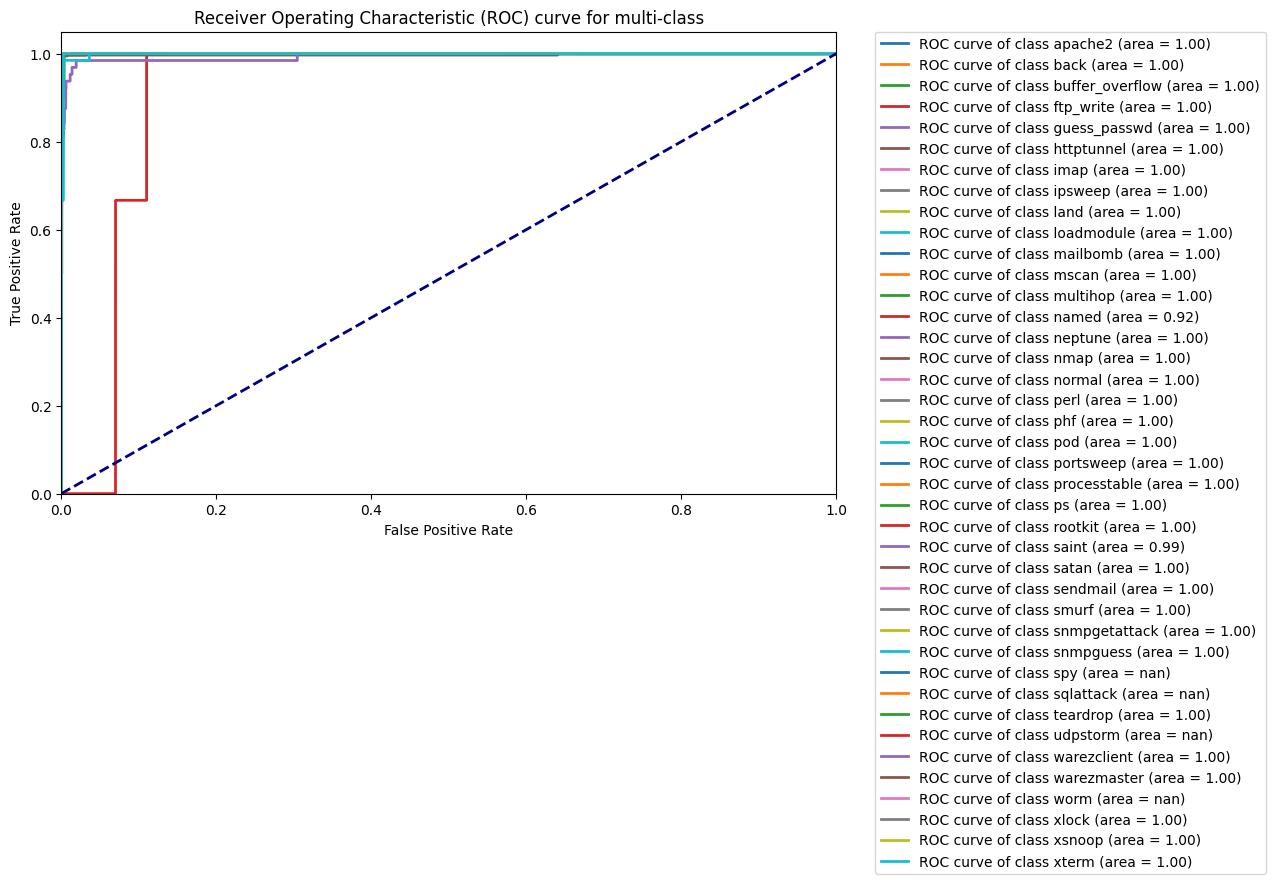

transformer_ids_model 


ValueError: ignored

In [ ]:

model_name = 'transformer_ids_model'
plot_roc_curve(y_test, y_score, le, model_name)
# Print scores
print("transformer_ids_model ")
print_score(y_pred, y_test, y_score, le, model_name)
plot_precision_recall_curve(y_test, y_score, le, model_name)
plot_class_accuracy(y_test, y_pred, le, model_name)
plot_class_f1_score(y_test, y_pred, le, model_name)

Epoch 1/50
1486/1486 [==============================] - 22s 14ms/step - loss: 0.1499 - accuracy: 0.9693 - val_loss: 0.0336 - val_accuracy: 0.9915
Epoch 2/50
1486/1486 [==============================] - 20s 14ms/step - loss: 0.0438 - accuracy: 0.9900 - val_loss: 0.0254 - val_accuracy: 0.9938
Epoch 3/50
1486/1486 [==============================] - 20s 13ms/step - loss: 0.0313 - accuracy: 0.9924 - val_loss: 0.0217 - val_accuracy: 0.9936
Epoch 4/50
1486/1486 [==============================] - 21s 14ms/step - loss: 0.0259 - accuracy: 0.9934 - val_loss: 0.0182 - val_accuracy: 0.9955
Epoch 5/50
1486/1486 [==============================] - 21s 14ms/step - loss: 0.0229 - accuracy: 0.9940 - val_loss: 0.0173 - val_accuracy: 0.9951
Epoch 6/50
1486/1486 [==============================] - 20s 14ms/step - loss: 0.0190 - accuracy: 0.9945 - val_loss: 0.0160 - val_accuracy: 0.9965
Epoch 7/50
1486/1486 [==============================] - 21s 14ms/step - loss: 0.0178 - accuracy: 0.9950 - val_loss: 0.0148 -

Metric     Value
0               Accuracy  0.998115
1      Precision (macro)  0.886375
2         Recall (macro)  0.854675
3       F1-score (macro)  0.857466
4    Precision (apache2)  1.000000
..                   ...       ...
119      Recall (xsnoop)  1.000000
120    F1-score (xsnoop)  0.666667
121    Precision (xterm)  0.666667
122       Recall (xterm)  0.666667
123     F1-score (xterm)  0.666667

[124 rows x 2 columns]

Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


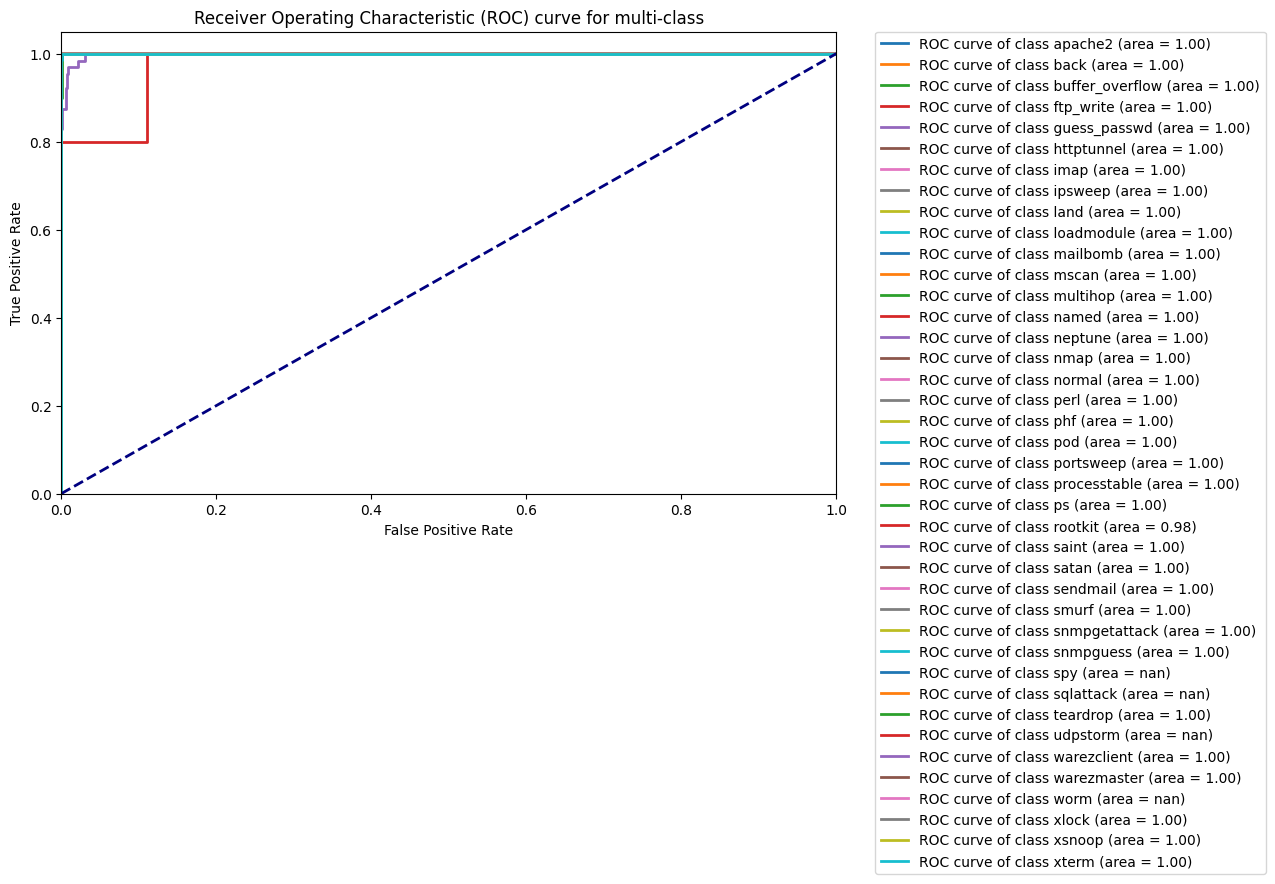

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

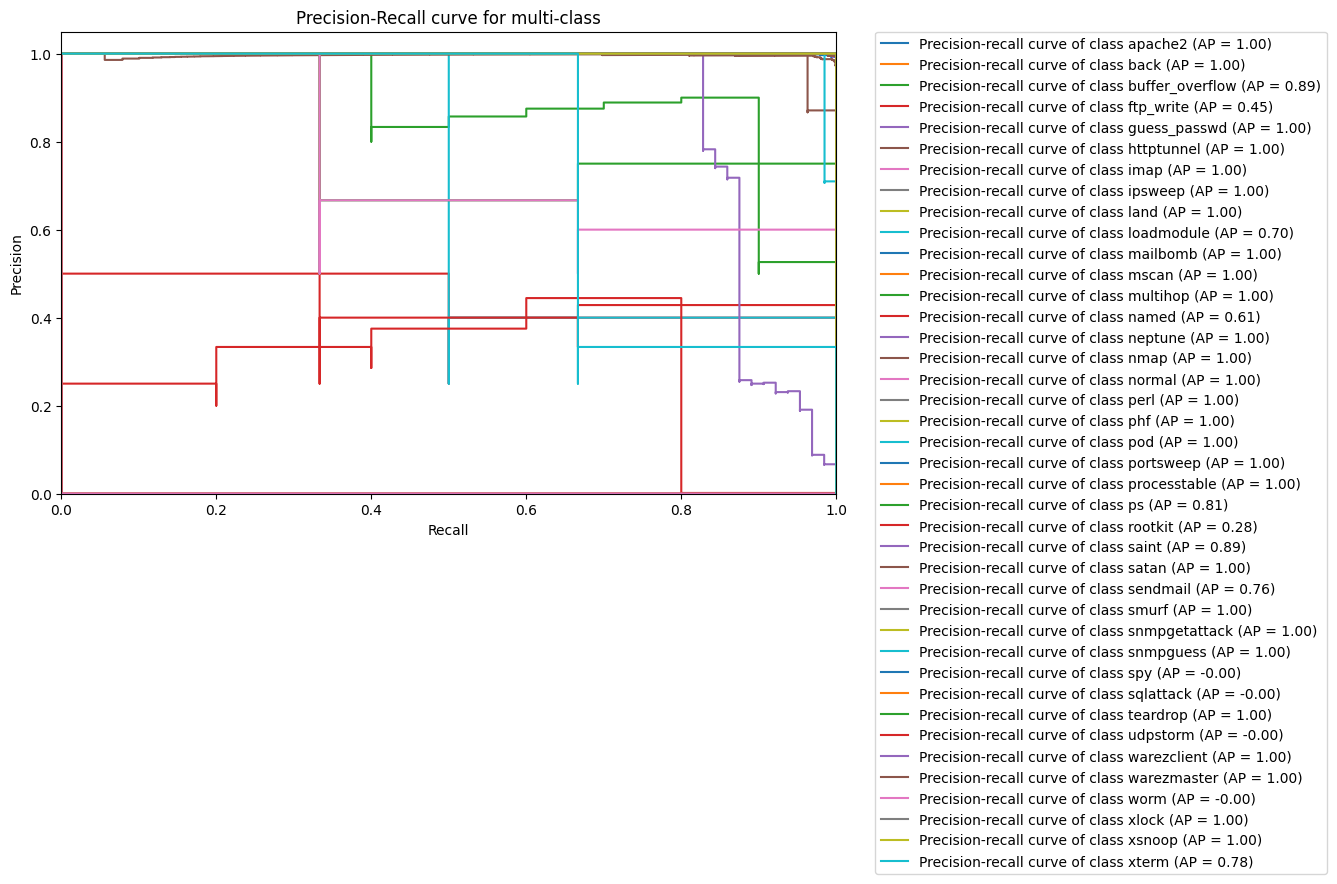

<ipython-input-10-6f21ff871c45>:140: RuntimeWarning: invalid value encountered in true_divide
  class_accuracies = class_corrects / class_counts


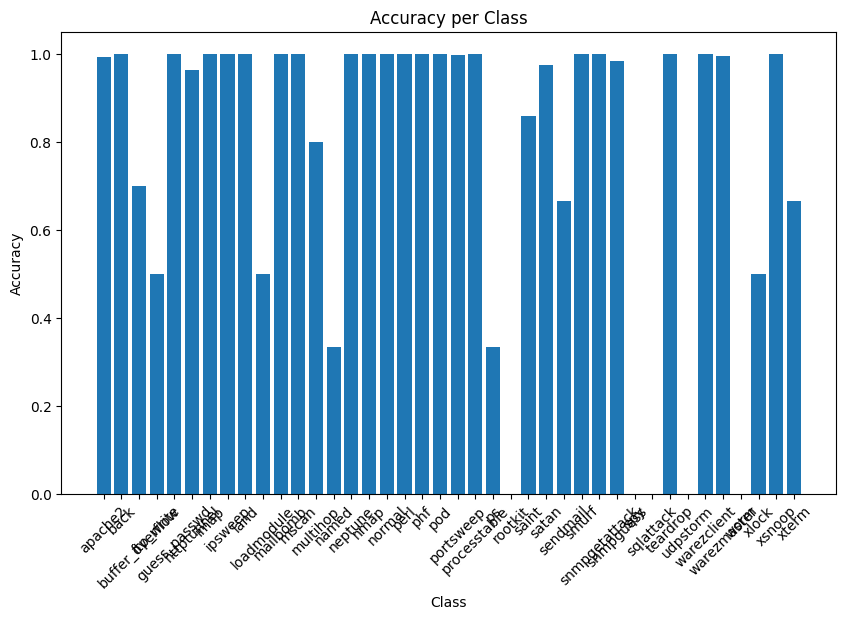

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

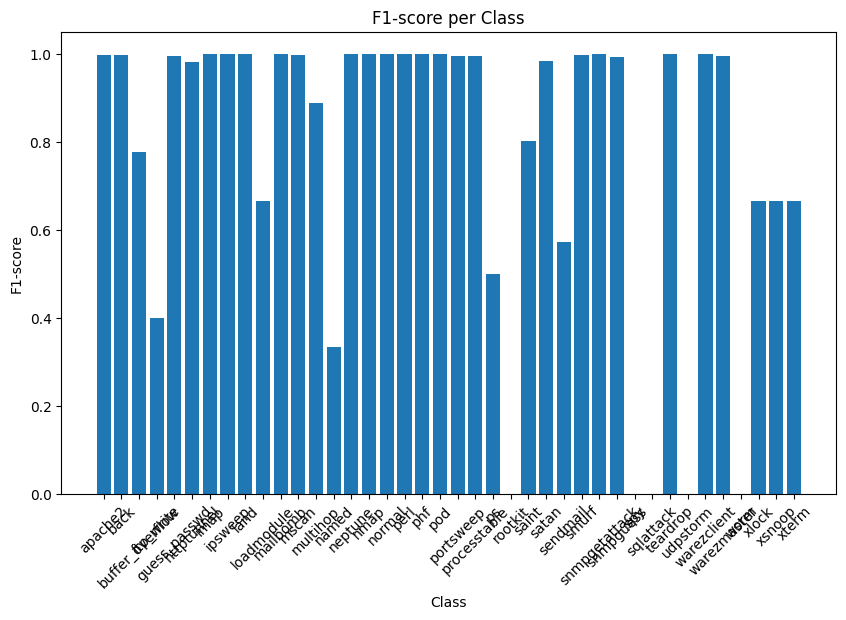

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# One-hot encode the categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
df = pd.get_dummies(df, columns=cat_cols)

# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['label']

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data into 3D format for use with Conv1D (samples, timesteps, features)
X_train_scaled_3d = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled_3d = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


# Define the CNN architecture
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_scaled_3d.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# One-hot encode the training and test labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Then use these one-hot encoded labels to train and evaluate the model
model.fit(X_train_scaled_3d, y_train_encoded, batch_size=64, epochs=50, validation_split=0.2,  callbacks=[early_stopping])

score = model.evaluate(X_test_scaled_3d, y_test_encoded)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Calculate prediction probabilities
y_score = model.predict(X_test_scaled_3d)
y_pred = np.argmax(y_score, axis=-1)
# Convert one-hot encoded y_test_encoded to class labels
y_test_labels = np.argmax(y_test_encoded, axis=-1)
model_name = "CNN"
# Print scores
print_score(y_pred, y_test_labels, y_score, label_encoder, model_name)
plot_roc_curve(y_test_labels, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test_labels, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test_labels, y_pred, label_encoder, model_name)

Epoch 1/100
1300/1300 [==============================] - 6s 4ms/step - loss: 0.6028 - accuracy: 0.8589 - val_loss: 0.1604 - val_accuracy: 0.9538
Epoch 2/100
1300/1300 [==============================] - 4s 3ms/step - loss: 0.2531 - accuracy: 0.9253 - val_loss: 0.0981 - val_accuracy: 0.9788
Epoch 3/100
1300/1300 [==============================] - 4s 3ms/step - loss: 0.2001 - accuracy: 0.9418 - val_loss: 0.0728 - val_accuracy: 0.9856
Epoch 4/100
1300/1300 [==============================] - 4s 3ms/step - loss: 0.1672 - accuracy: 0.9501 - val_loss: 0.0590 - val_accuracy: 0.9879
Epoch 5/100
1300/1300 [==============================] - 4s 3ms/step - loss: 0.1457 - accuracy: 0.9566 - val_loss: 0.0555 - val_accuracy: 0.9882
Epoch 6/100
1300/1300 [==============================] - 4s 3ms/step - loss: 0.1349 - accuracy: 0.9596 - val_loss: 0.0510 - val_accuracy: 0.9893
Epoch 7/100
1300/1300 [==============================] - 4s 3ms/step - loss: 0.1211 - accuracy: 0.9635 - val_loss: 0.0455 - val_ac

Metric     Value
0               Accuracy  0.994210
1      Precision (macro)  0.958084
2         Recall (macro)  0.480090
3       F1-score (macro)  0.475938
4    Precision (apache2)  1.000000
..                   ...       ...
119      Recall (xsnoop)  0.000000
120    F1-score (xsnoop)  0.000000
121    Precision (xterm)  1.000000
122       Recall (xterm)  0.000000
123     F1-score (xterm)  0.000000

[124 rows x 2 columns]

Number of classes: 40
Shape of y_score: (44556, 40)


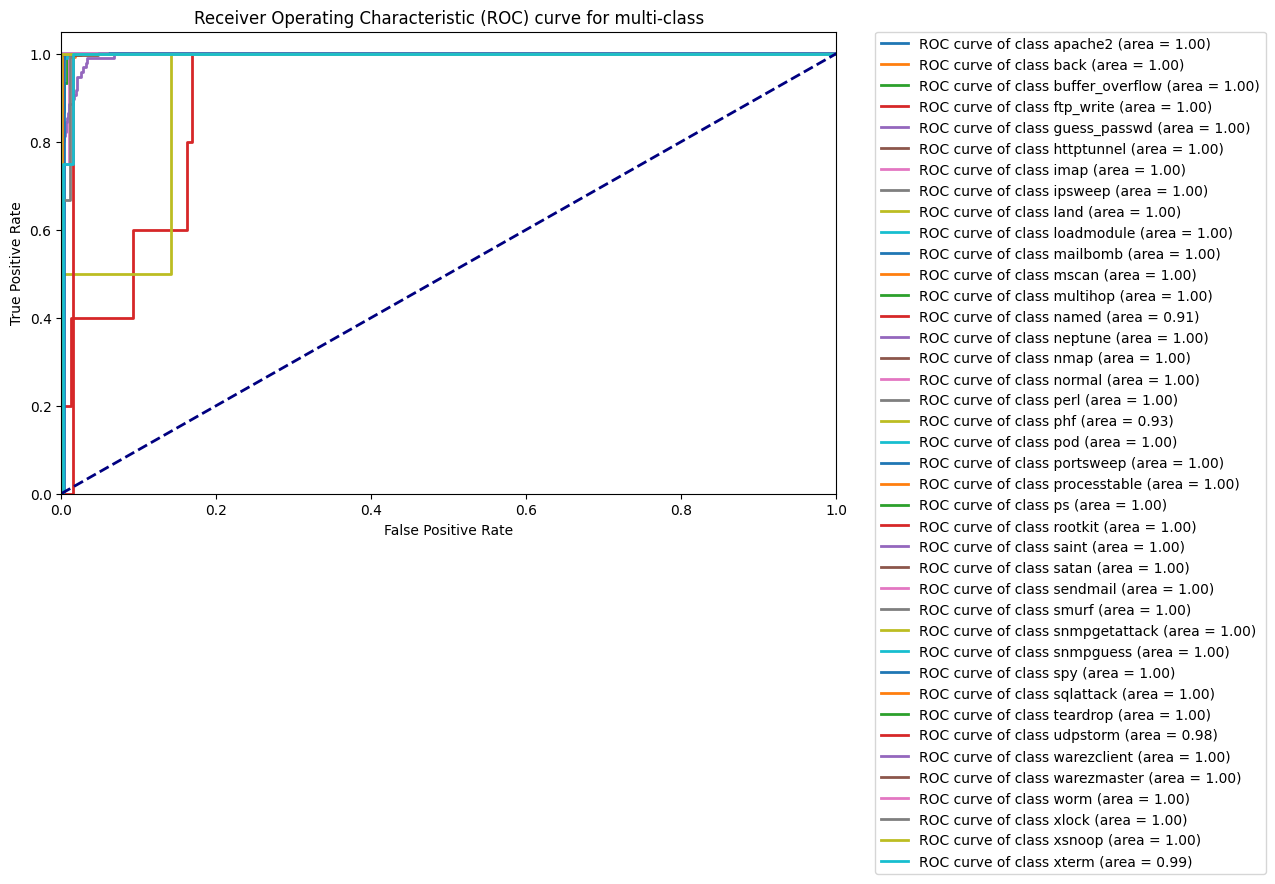

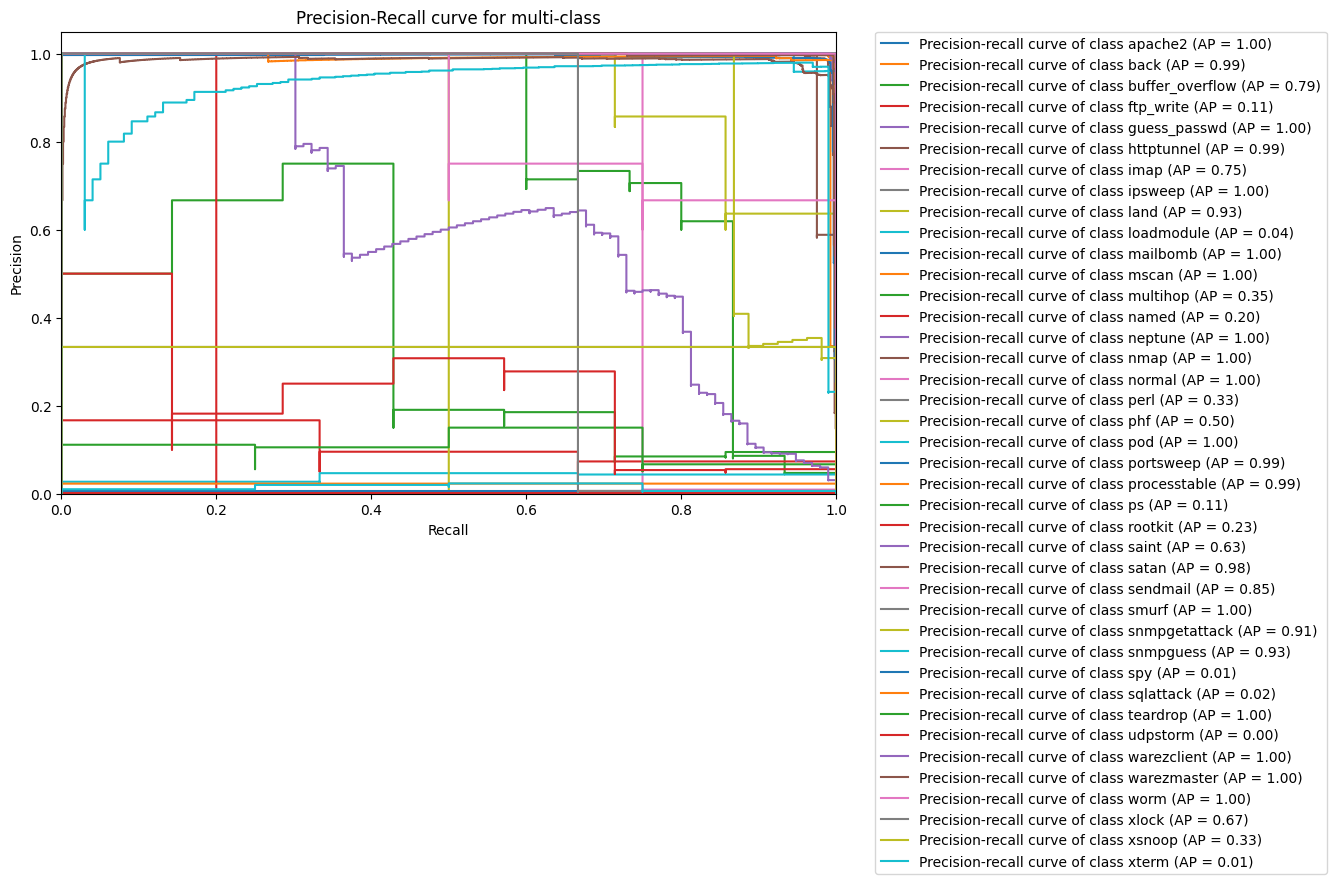

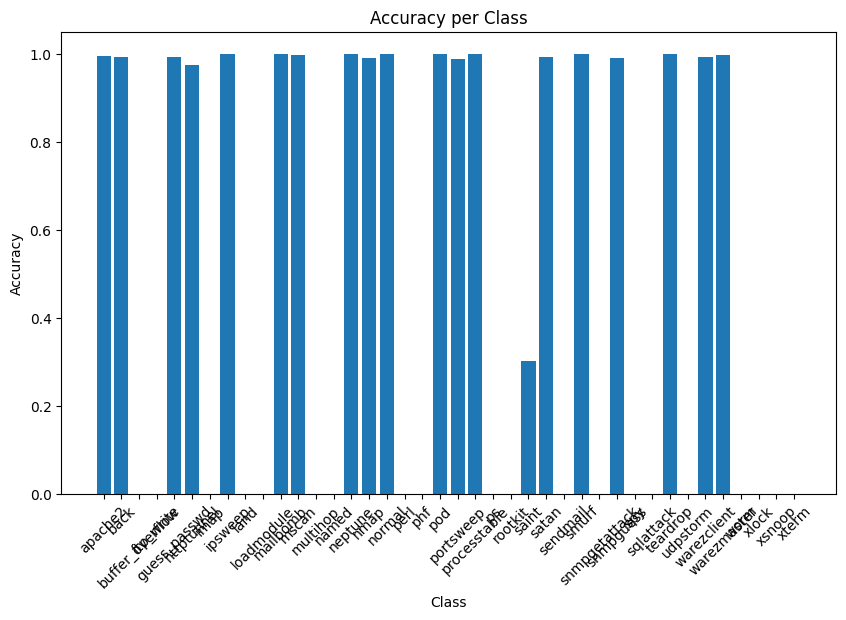

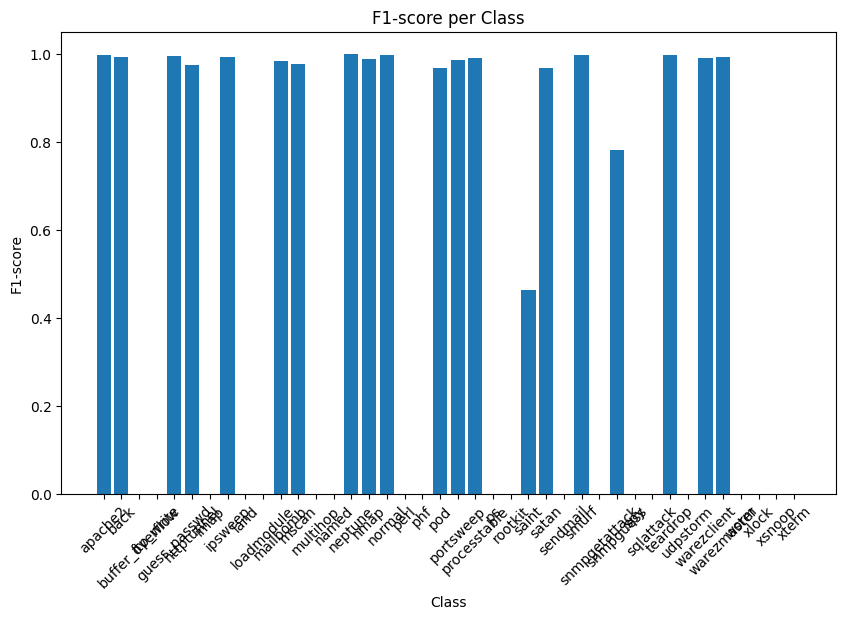

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


model_name = 'LSTM'

# One-hot encode the categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
df = pd.get_dummies(df, columns=cat_cols)

# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Split the dataset into features and labels
X = df.iloc[:, :-1].values
y = df['label']


# One-hot encode the target variable for use with a CNN
y_onehot = to_categorical(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42,  stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Reshape the input data into 3D format for use with LSTM (samples, timesteps, features)
# Ensure that the data is reshaped appropriately for a time series dataset
timesteps = 1  # Modify this value based on the dataset's structure
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1])

# Define the LSTM architecture
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(timesteps, X_train_scaled.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# Train the model
model.fit(X_train_scaled, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])


# Make predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# Calculate prediction probabilities
y_score = model.predict(X_test_scaled)

# Convert one-hot encoded y_test to class labels
y_test_labels = np.argmax(y_test, axis=-1)

# Print scores
print_score(y_pred, y_test_labels, y_score, label_encoder, model_name)
plot_roc_curve(y_test_labels, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test_labels, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test_labels, y_pred, label_encoder, model_name)

Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


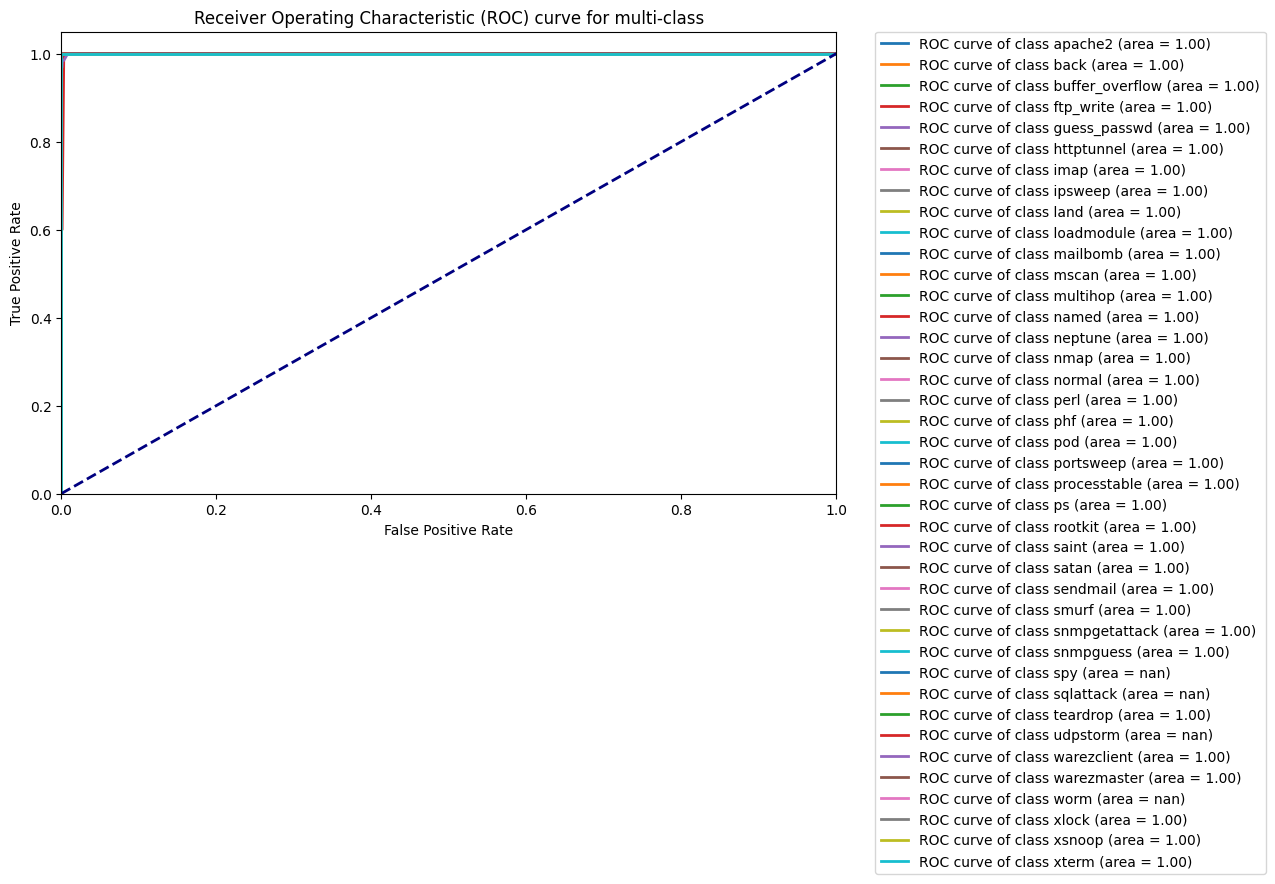

Random Forest Classifier


Metric     Value
0               Accuracy  0.999091
1      Precision (macro)  0.981628
2         Recall (macro)  0.848744
3       F1-score (macro)  0.867189
4    Precision (apache2)  1.000000
..                   ...       ...
119      Recall (xsnoop)  0.000000
120    F1-score (xsnoop)  0.000000
121    Precision (xterm)  1.000000
122       Recall (xterm)  0.333333
123     F1-score (xterm)  0.500000

[124 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

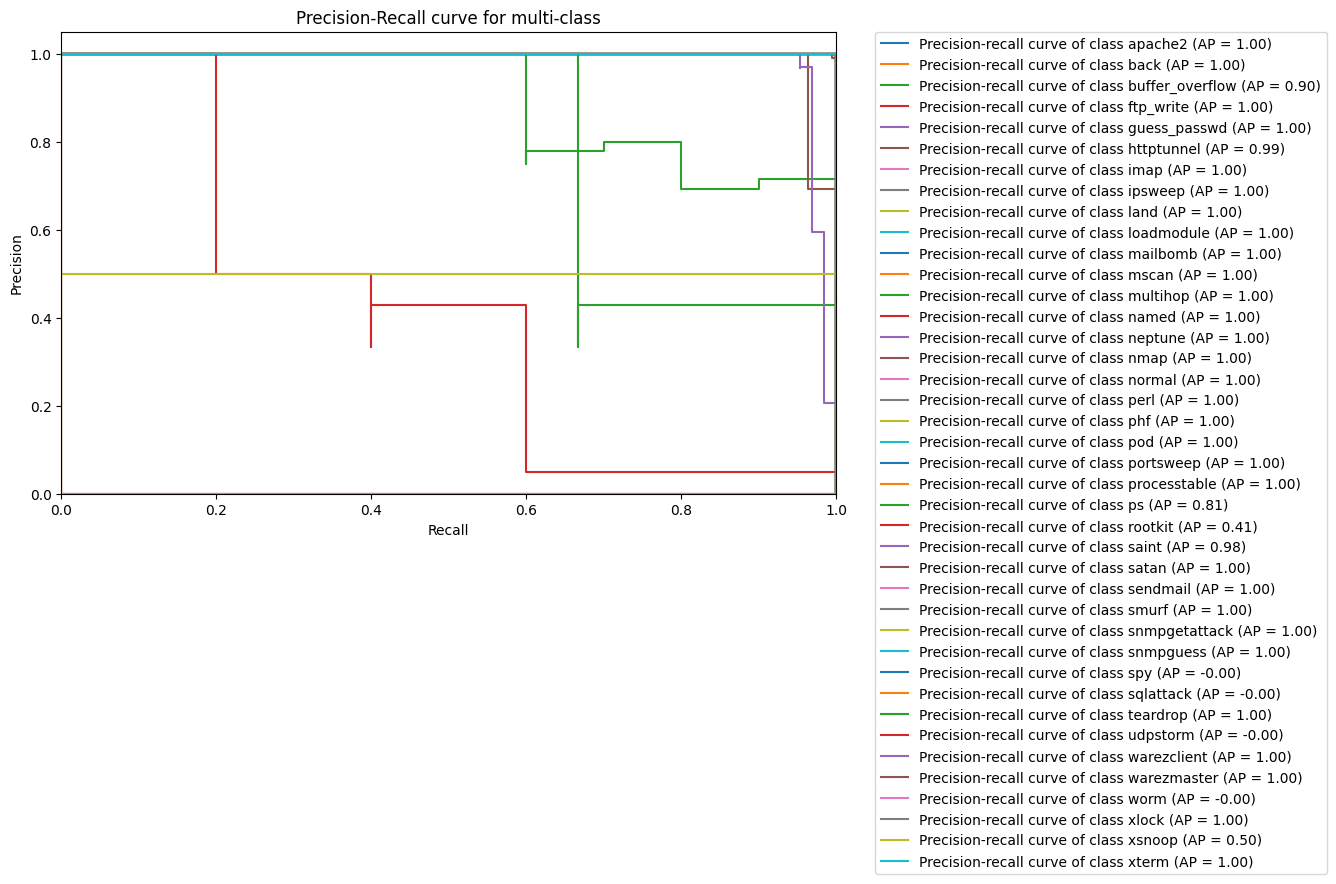

<ipython-input-2-6f21ff871c45>:140: RuntimeWarning: invalid value encountered in true_divide
  class_accuracies = class_corrects / class_counts


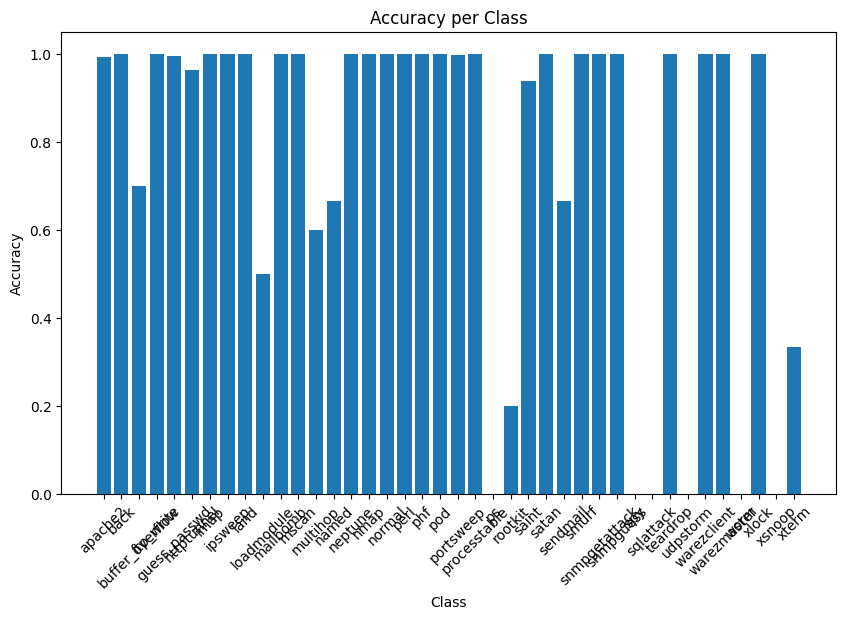

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

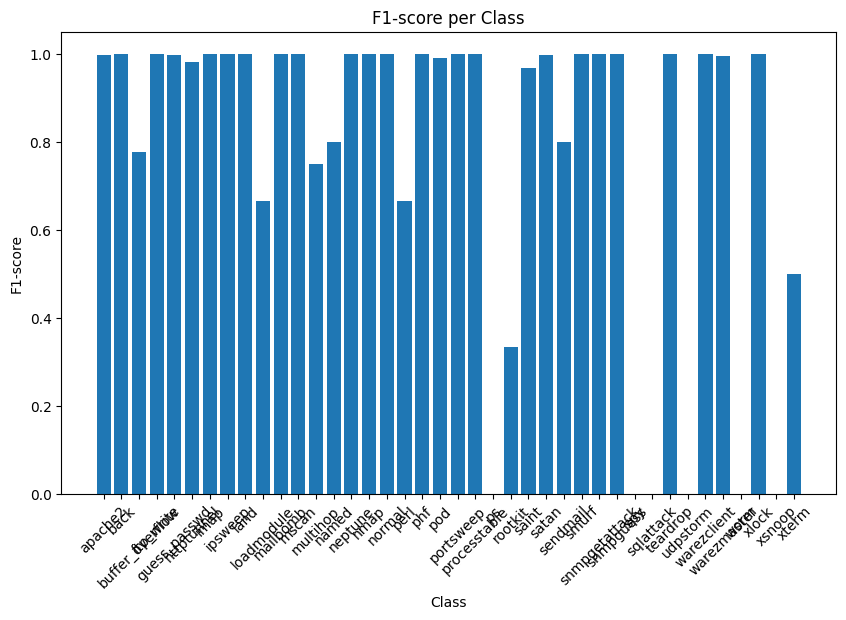

In [ ]:
# # Train the Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = rf_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = rf_classifier.predict_proba(X_test_scaled)

# model_name = 'RandomForest'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# # Print scores
# print("Random Forest Classifier")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


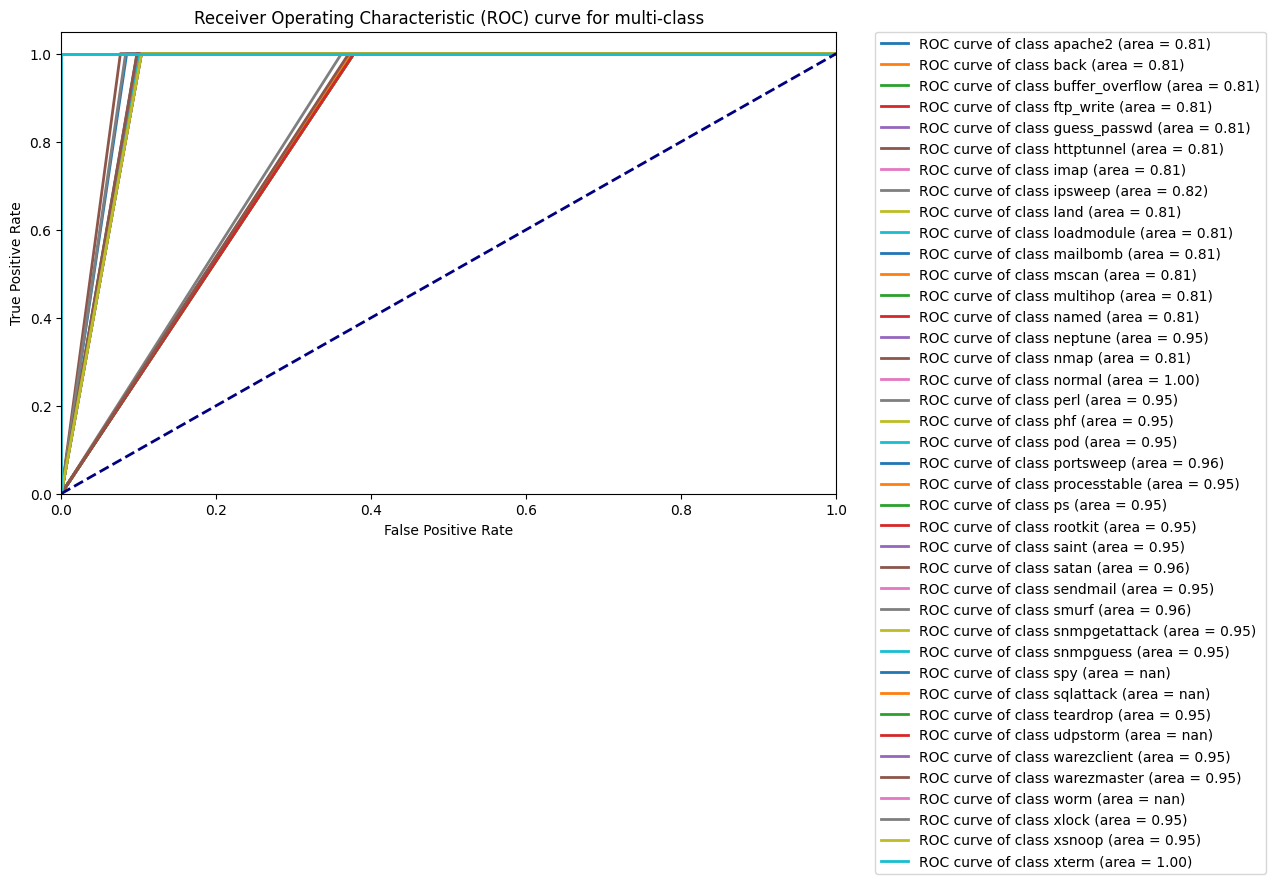

Adaboost 


Metric     Value
0               Accuracy  0.857191
1      Precision (macro)  0.975063
2         Recall (macro)  0.111111
3       F1-score (macro)  0.092852
4    Precision (apache2)  1.000000
..                   ...       ...
119      Recall (xsnoop)  0.000000
120    F1-score (xsnoop)  0.000000
121    Precision (xterm)  1.000000
122       Recall (xterm)  1.000000
123     F1-score (xterm)  1.000000

[124 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

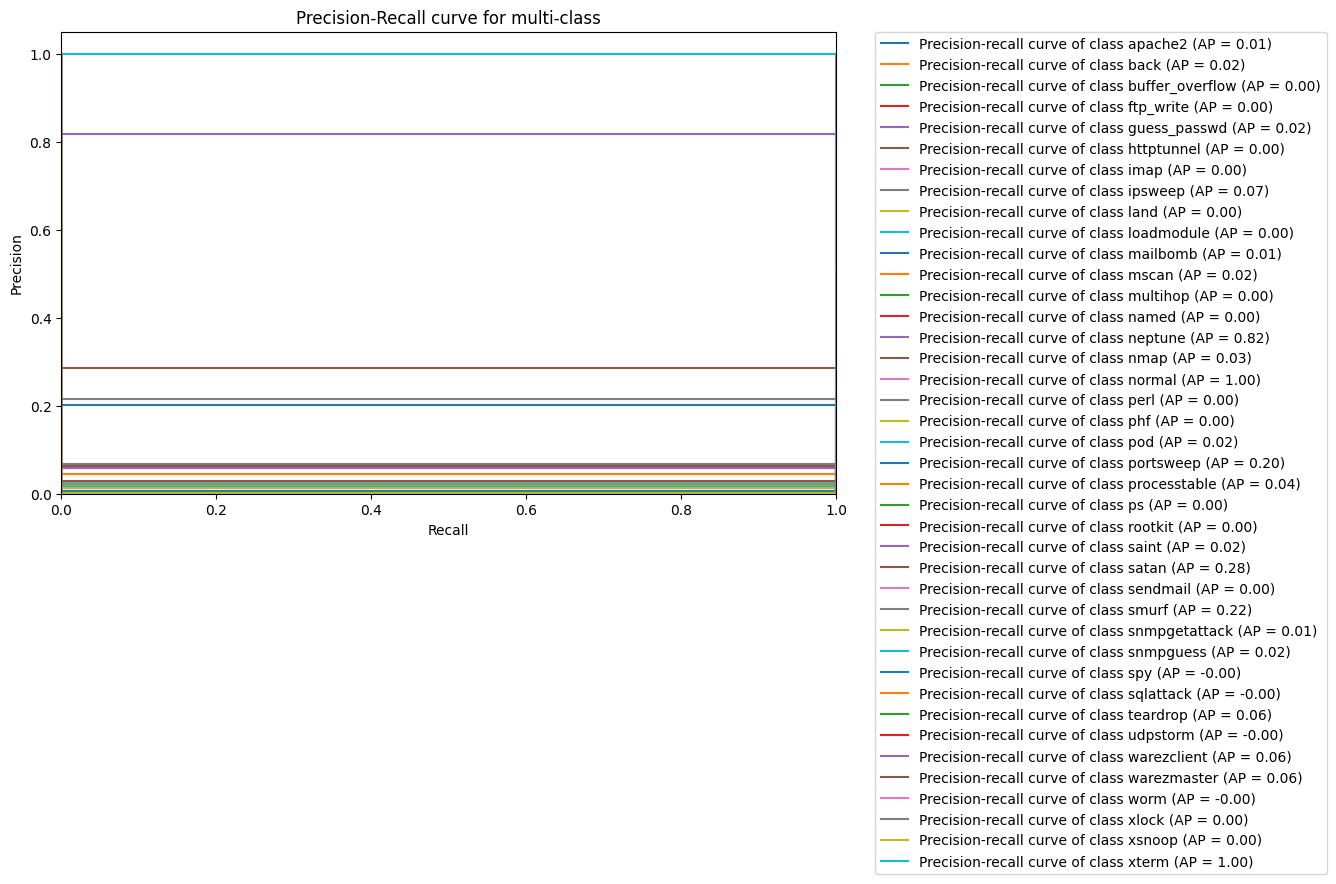

<ipython-input-2-6f21ff871c45>:140: RuntimeWarning: invalid value encountered in true_divide
  class_accuracies = class_corrects / class_counts


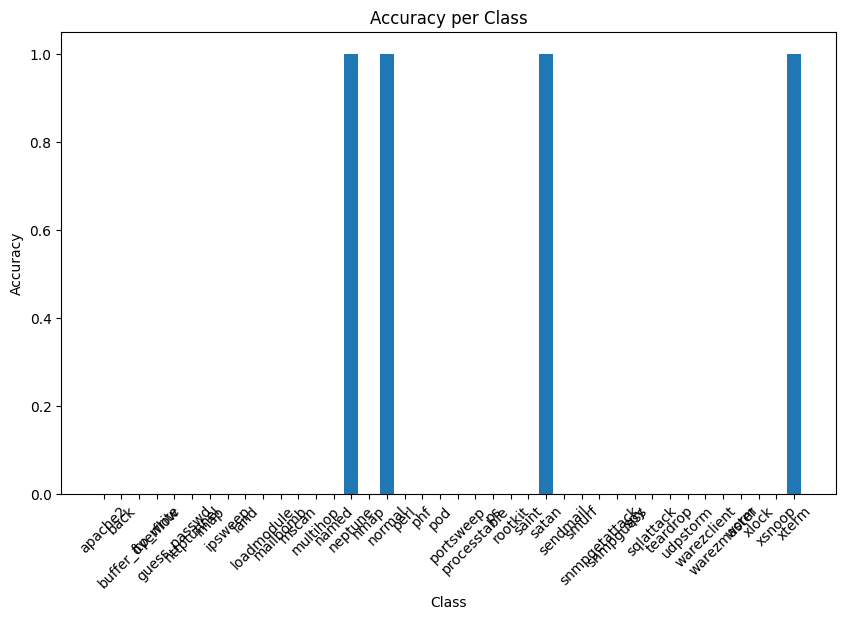

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

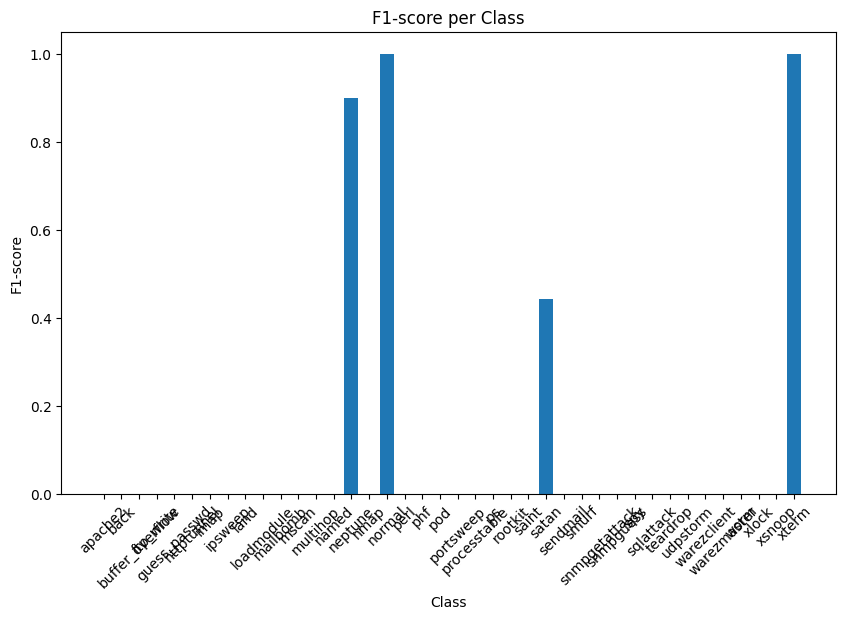

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier
# # Train the AdaBoost Classifier
# adaboost_classifier = AdaBoostClassifier(random_state=42)
# adaboost_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = adaboost_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = adaboost_classifier.predict_proba(X_test_scaled)
# model_name = 'Adaboost'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)

# print("Adaboost ")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


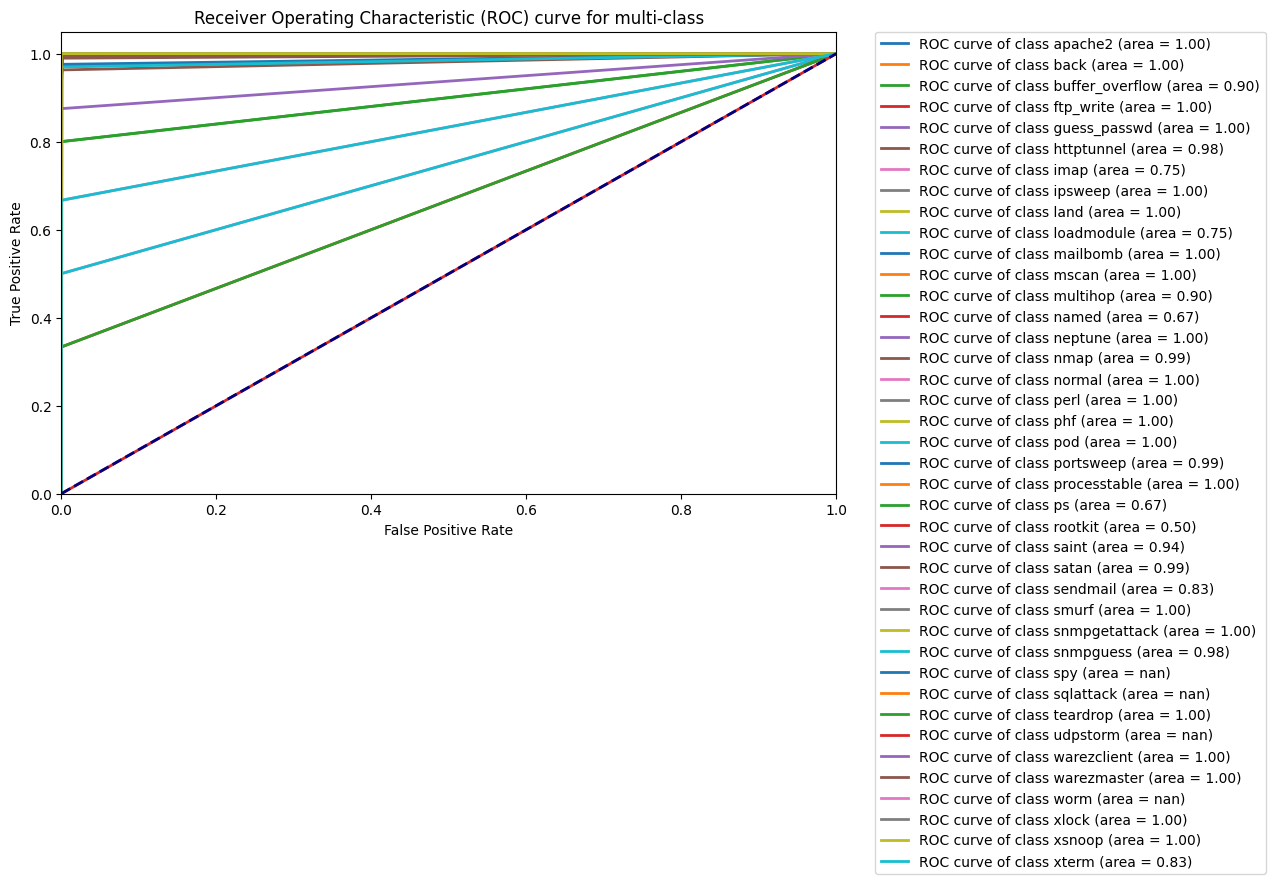

KNN 


Metric     Value
0               Accuracy  0.994142
1      Precision (macro)  0.849175
2         Recall (macro)  0.720316
3       F1-score (macro)  0.708779
4    Precision (apache2)  1.000000
..                   ...       ...
119      Recall (xsnoop)  0.000000
120    F1-score (xsnoop)  0.000000
121    Precision (xterm)  0.500000
122       Recall (xterm)  0.666667
123     F1-score (xterm)  0.571429

[124 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

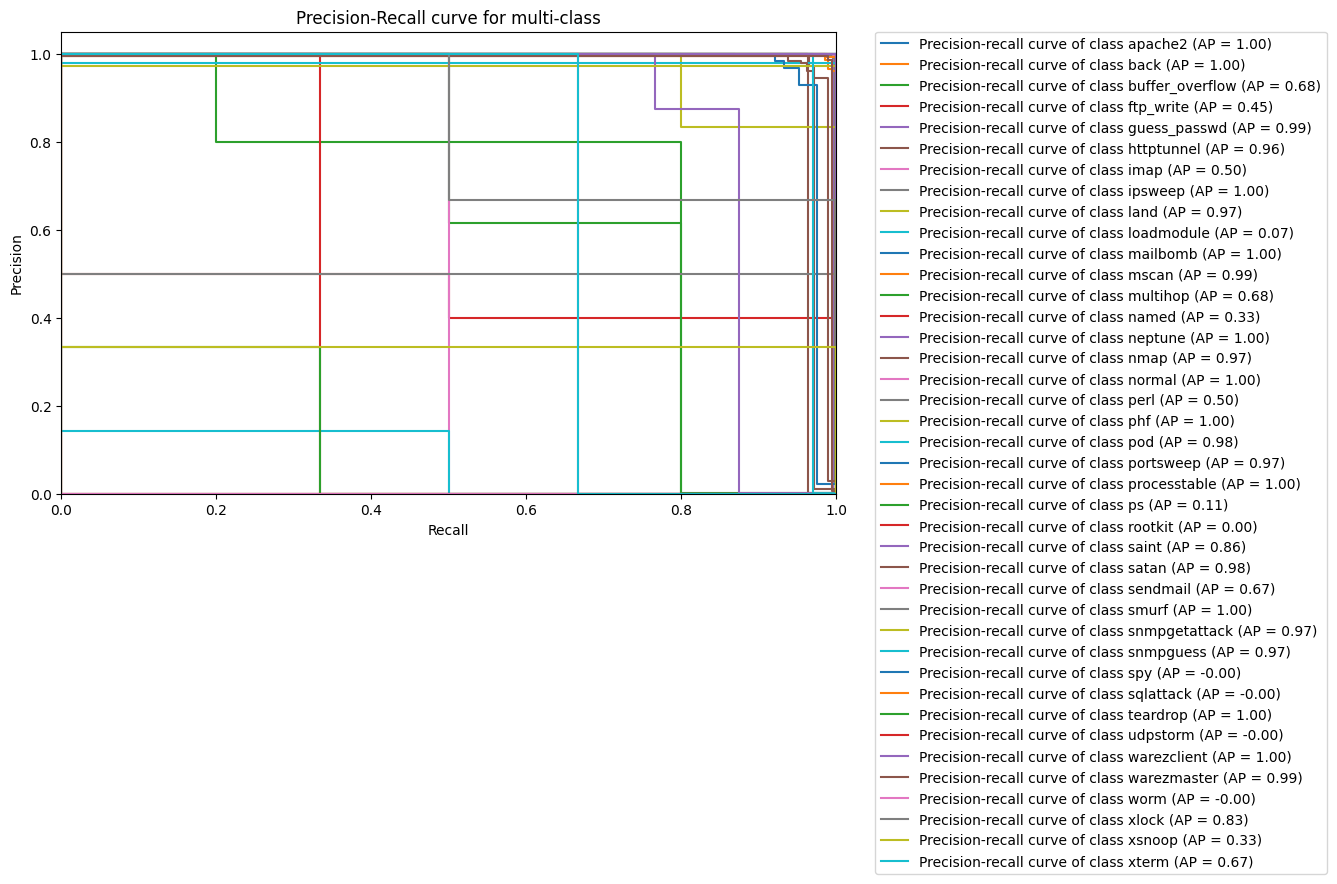

<ipython-input-2-6f21ff871c45>:140: RuntimeWarning: invalid value encountered in true_divide
  class_accuracies = class_corrects / class_counts


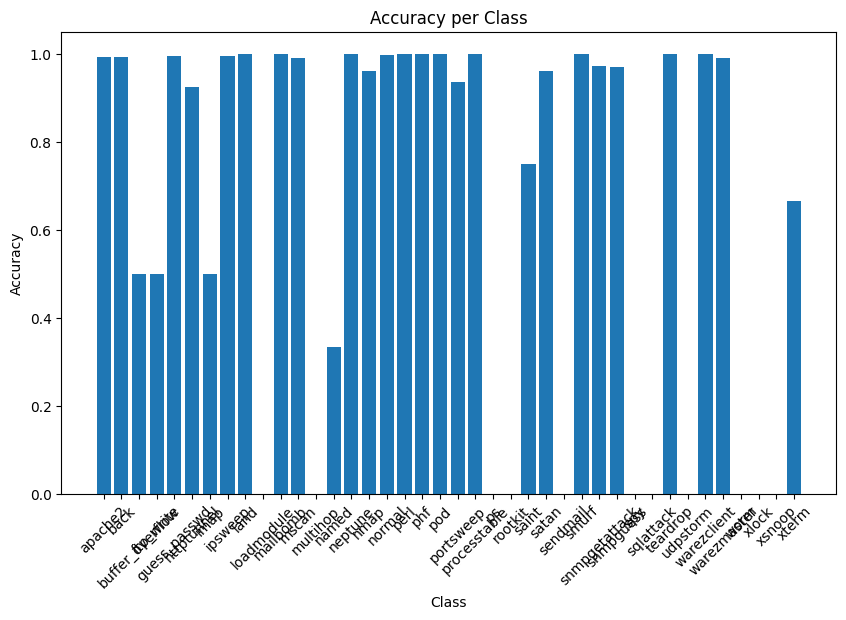

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

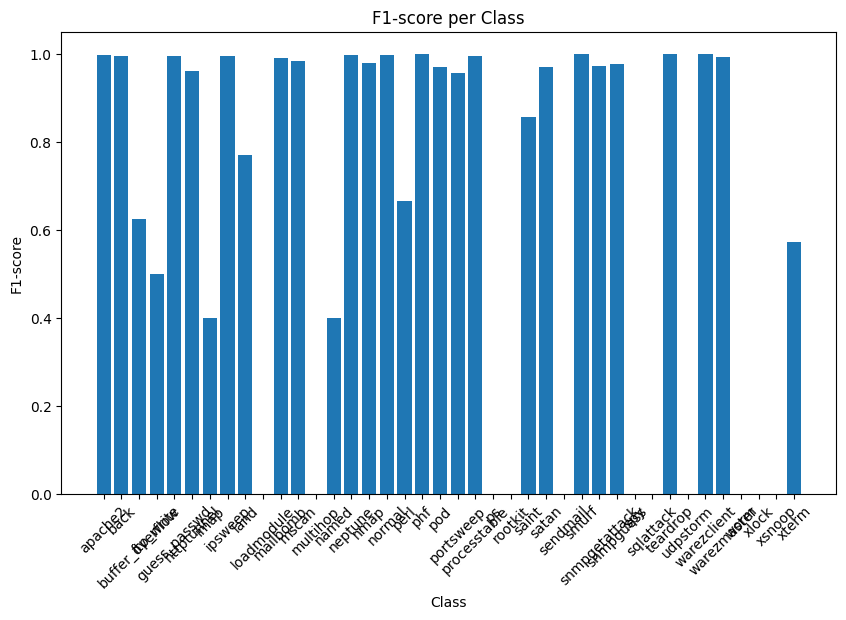

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# # Encode the target variable
# # label_encoder = LabelEncoder()
# # y_encoded = label_encoder.fit_transform(y)

# # # Split the dataset into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # # Scale the features
# # scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_test_scaled = scaler.transform(X_test)

# # Train the K-Nearest Neighbors Classifier
# knn_classifier = KNeighborsClassifier(n_neighbors=5)
# knn_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = knn_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = knn_classifier.predict_proba(X_test_scaled)
# model_name = 'KNN'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)

# print("KNN ")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


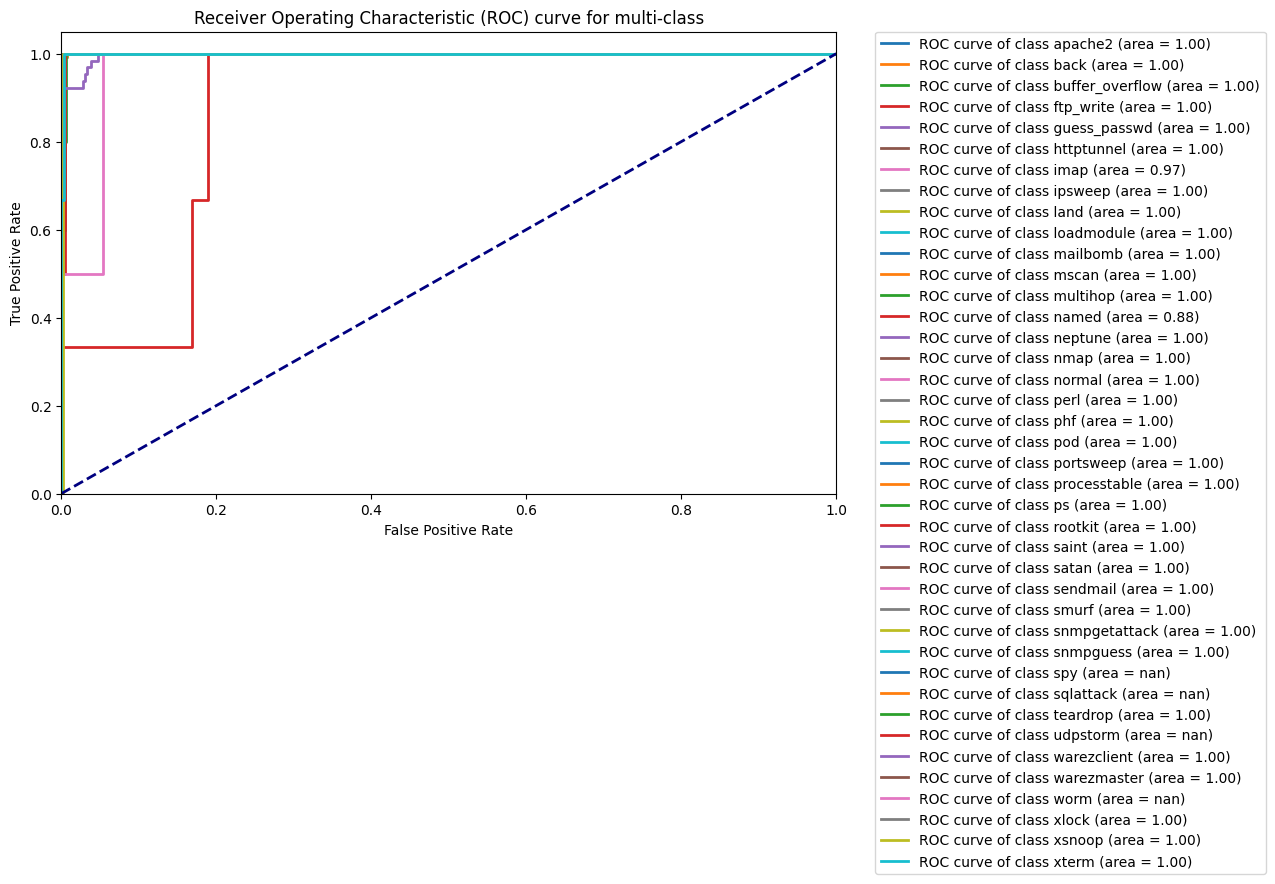

SVM 


Metric     Value
0               Accuracy  0.993301
1      Precision (macro)  0.895485
2         Recall (macro)  0.674047
3       F1-score (macro)  0.672457
4    Precision (apache2)  0.986486
..                   ...       ...
119      Recall (xsnoop)  0.000000
120    F1-score (xsnoop)  0.000000
121    Precision (xterm)  0.500000
122       Recall (xterm)  0.333333
123     F1-score (xterm)  0.400000

[124 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

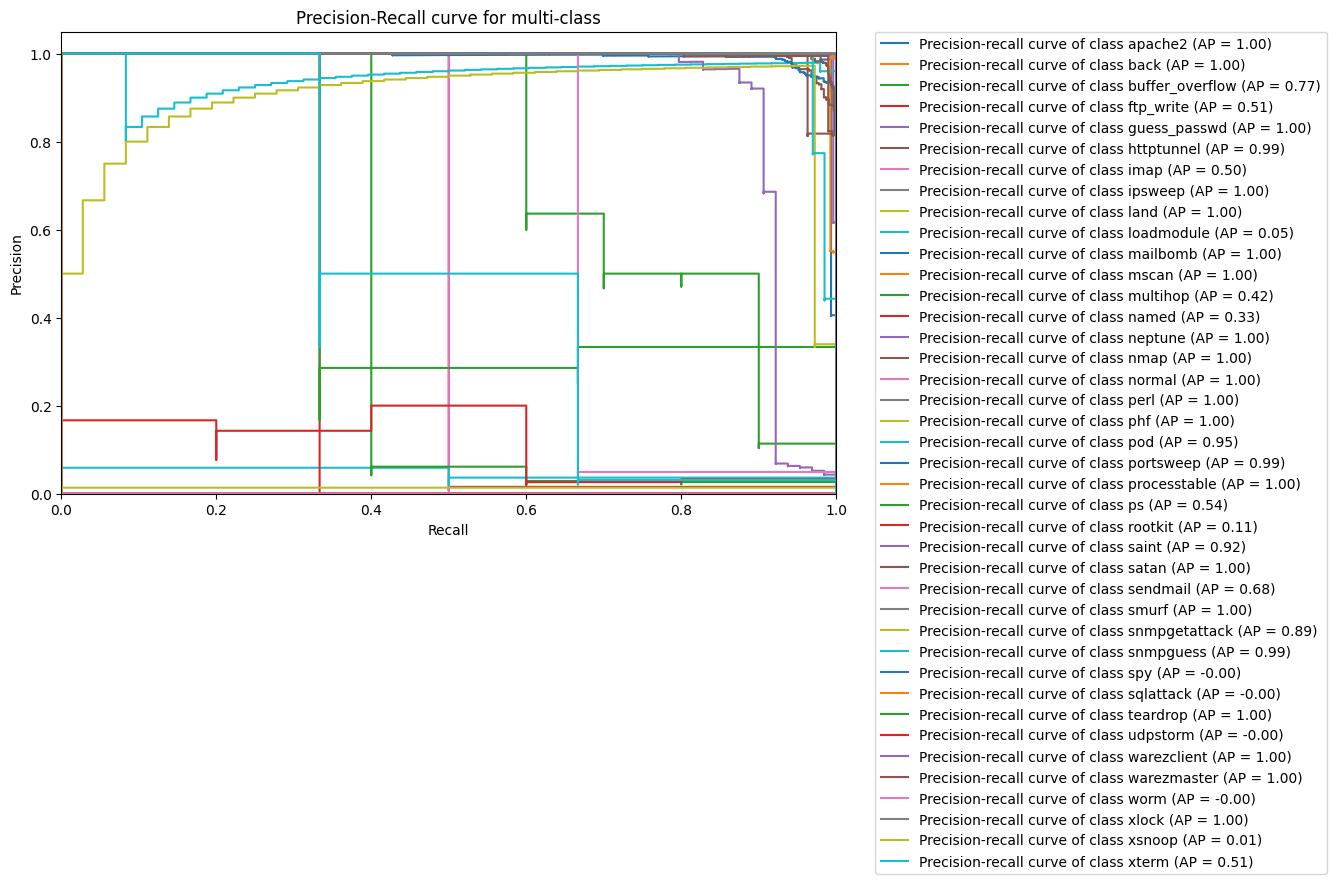

<ipython-input-2-6f21ff871c45>:140: RuntimeWarning: invalid value encountered in true_divide
  class_accuracies = class_corrects / class_counts


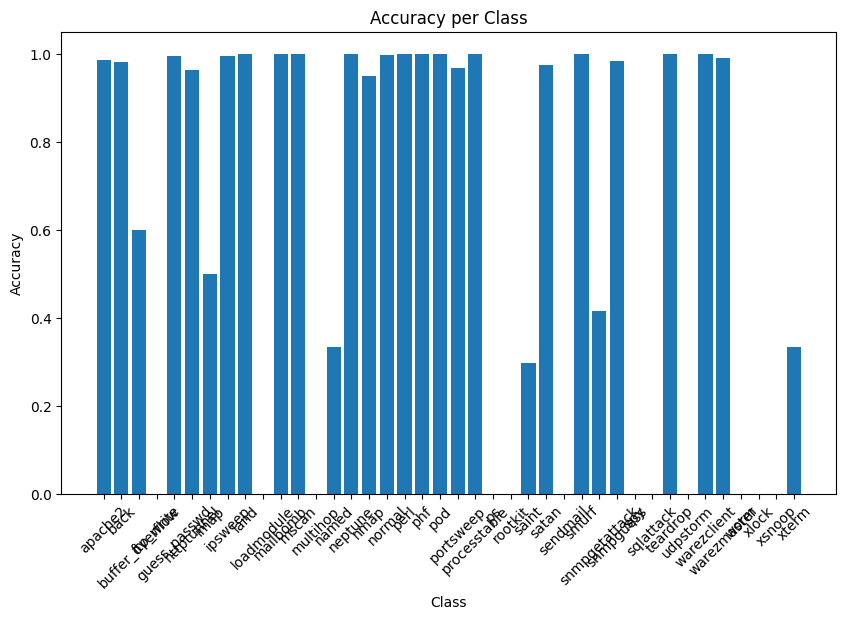

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

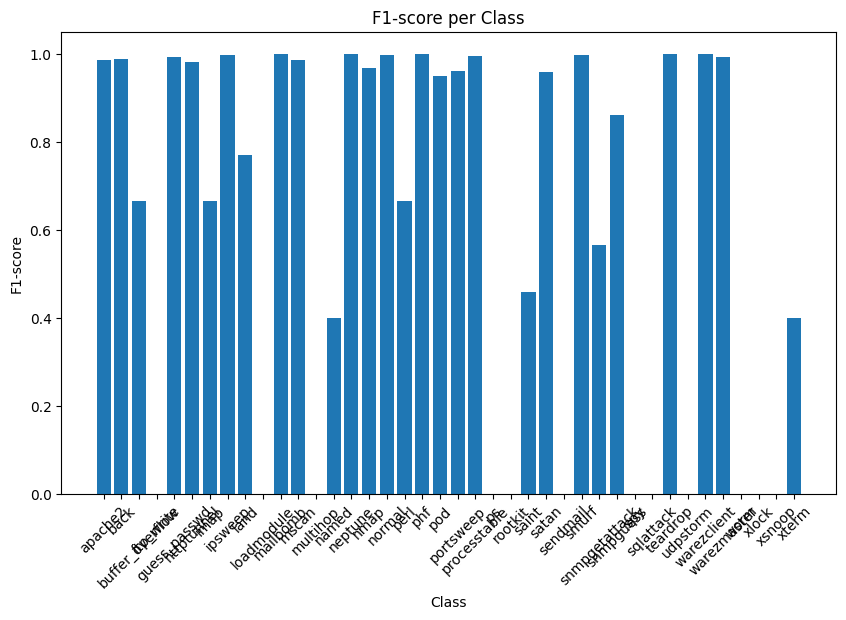

In [ ]:
# from sklearn.svm import SVC

# # One-hot encode the categorical columns
# cat_cols = ['protocol_type', 'service', 'flag']
# df = pd.get_dummies(df, columns=cat_cols)

# # Encode the labels
# label_encoder = LabelEncoder()
# df['label'] = label_encoder.fit_transform(df['label'])

# # Split the dataset into features and labels
# X = df.iloc[:, :-1].values
# y = df['label'].values

# # Split the data into training and testing datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Apply feature scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # Train the SVM Classifier
# svm_classifier = SVC(probability=True, random_state=42)
# svm_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = svm_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = svm_classifier.predict_proba(X_test_scaled)

# model_name = 'SVM'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# # Print scores
# print("SVM ")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)

Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


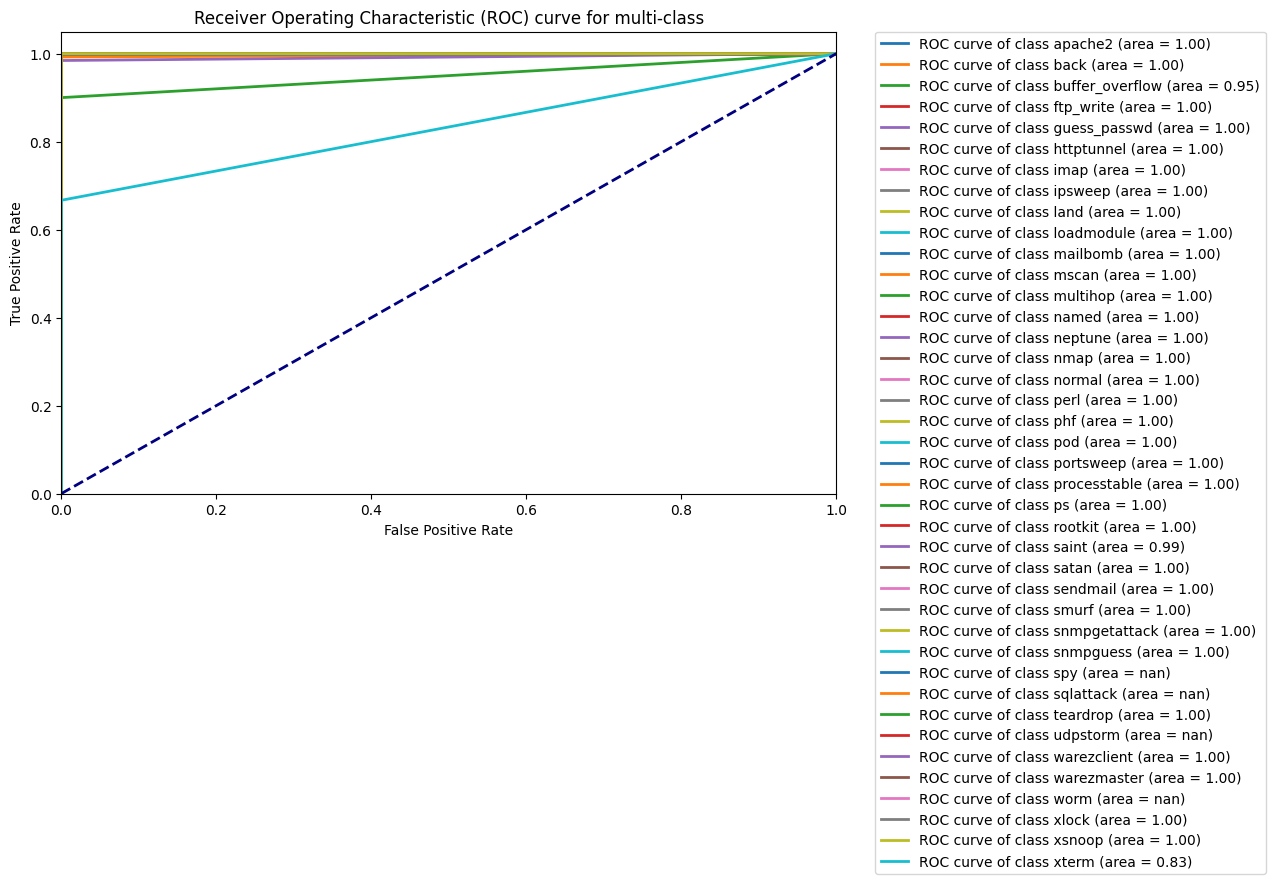

DecisionTree Classifier


Metric     Value
0               Accuracy  0.999832
1      Precision (macro)  0.978037
2         Recall (macro)  0.987318
3       F1-score (macro)  0.978700
4    Precision (apache2)  1.000000
..                   ...       ...
119      Recall (xsnoop)  1.000000
120    F1-score (xsnoop)  0.666667
121    Precision (xterm)  1.000000
122       Recall (xterm)  0.666667
123     F1-score (xterm)  0.800000

[124 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

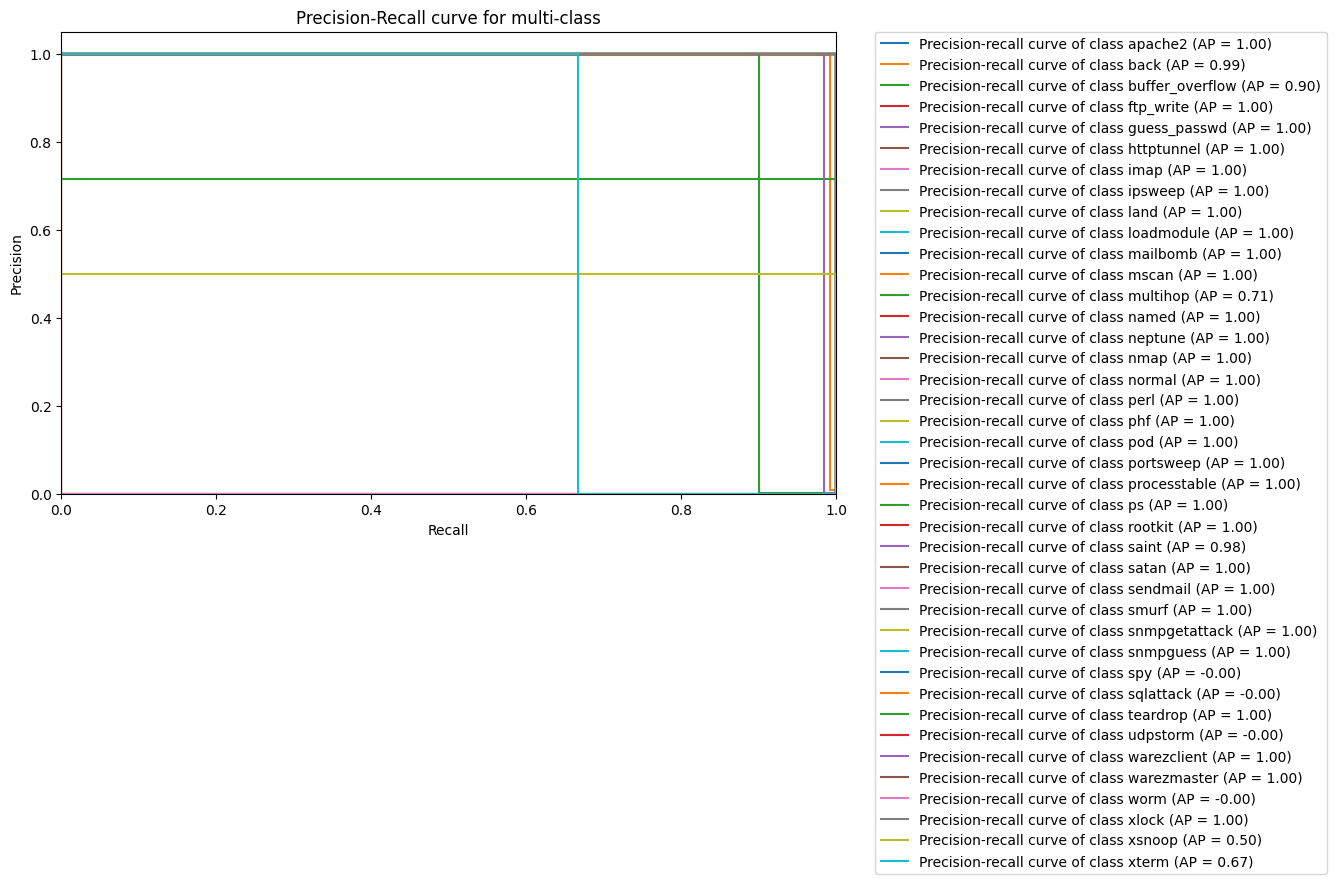

<ipython-input-17-6f21ff871c45>:140: RuntimeWarning: invalid value encountered in true_divide
  class_accuracies = class_corrects / class_counts


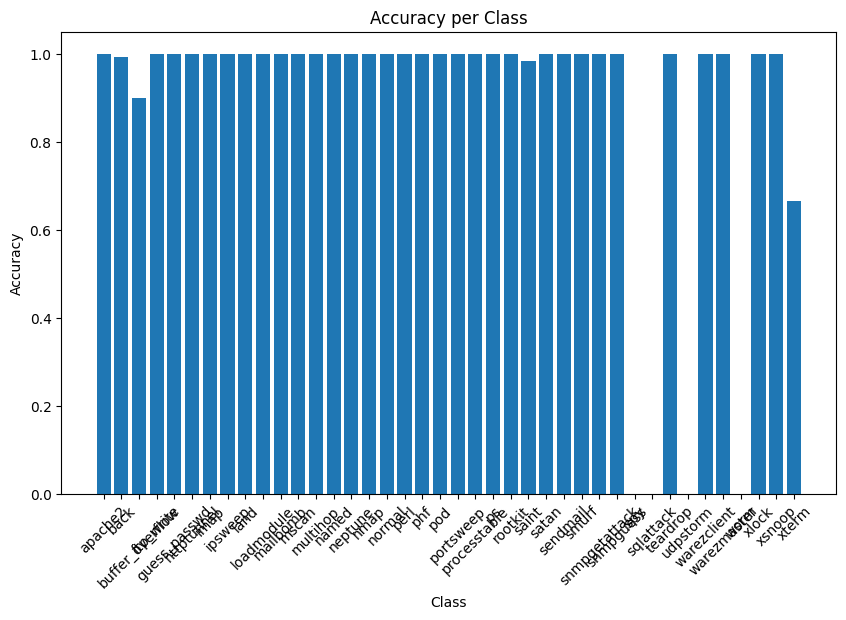

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

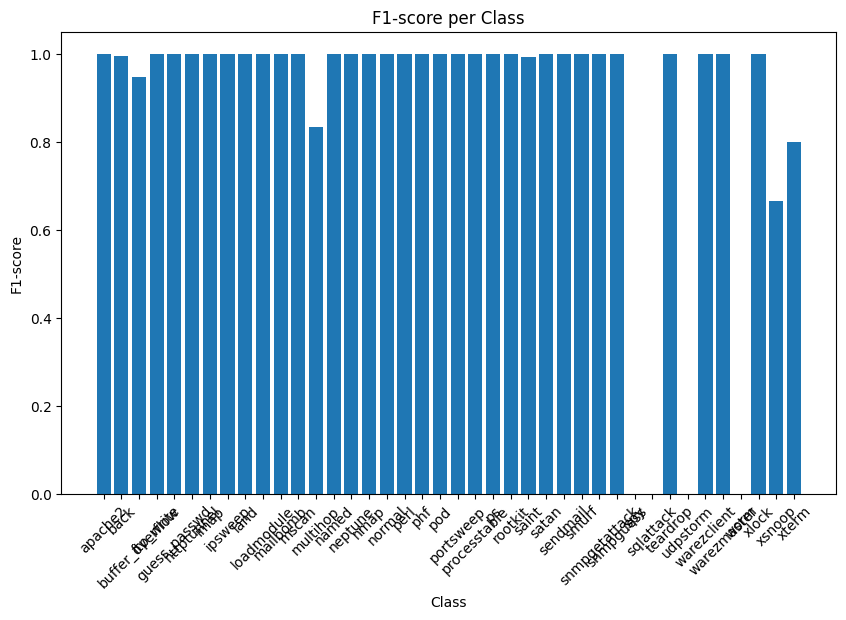

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from imblearn.over_sampling import SMOTE
# from sklearn.tree import DecisionTreeClassifier


# # One-hot encode the categorical columns
# cat_cols = ['protocol_type', 'service', 'flag']
# df = pd.get_dummies(df, columns=cat_cols)

# # Encode the labels
# le = LabelEncoder()
# df['label'] = le.fit_transform(df['label'])

# # Split the dataset into features and labels
# X = df.iloc[:, :-1].values
# y = df['label'].values

# # Split the data into training and testing datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Apply feature scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# dt_classifier = DecisionTreeClassifier(random_state=42)
# dt_classifier.fit(X_train, y_train)

# # Make predictions
# y_pred = dt_classifier.predict(X_test)

# # Get prediction scores
# y_score = dt_classifier.predict_proba(X_test)

# # Assume plot_roc_curve, print_score, plot_precision_recall_curve, plot_class_accuracy and plot_class_f1_score are defined functions
# model_name = 'DecisionTree'
# plot_roc_curve(y_test, y_score, le, model_name)

# # Print scores
# print("DecisionTree Classifier")
# print_score(y_pred, y_test, y_score, le, model_name)
# plot_precision_recall_curve(y_test, y_score, le, model_name)
# plot_class_accuracy(y_test, y_pred, le, model_name)
# plot_class_f1_score(y_test, y_pred, le, model_name)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of classes: 40
Shape of y_score: (29704, 40)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


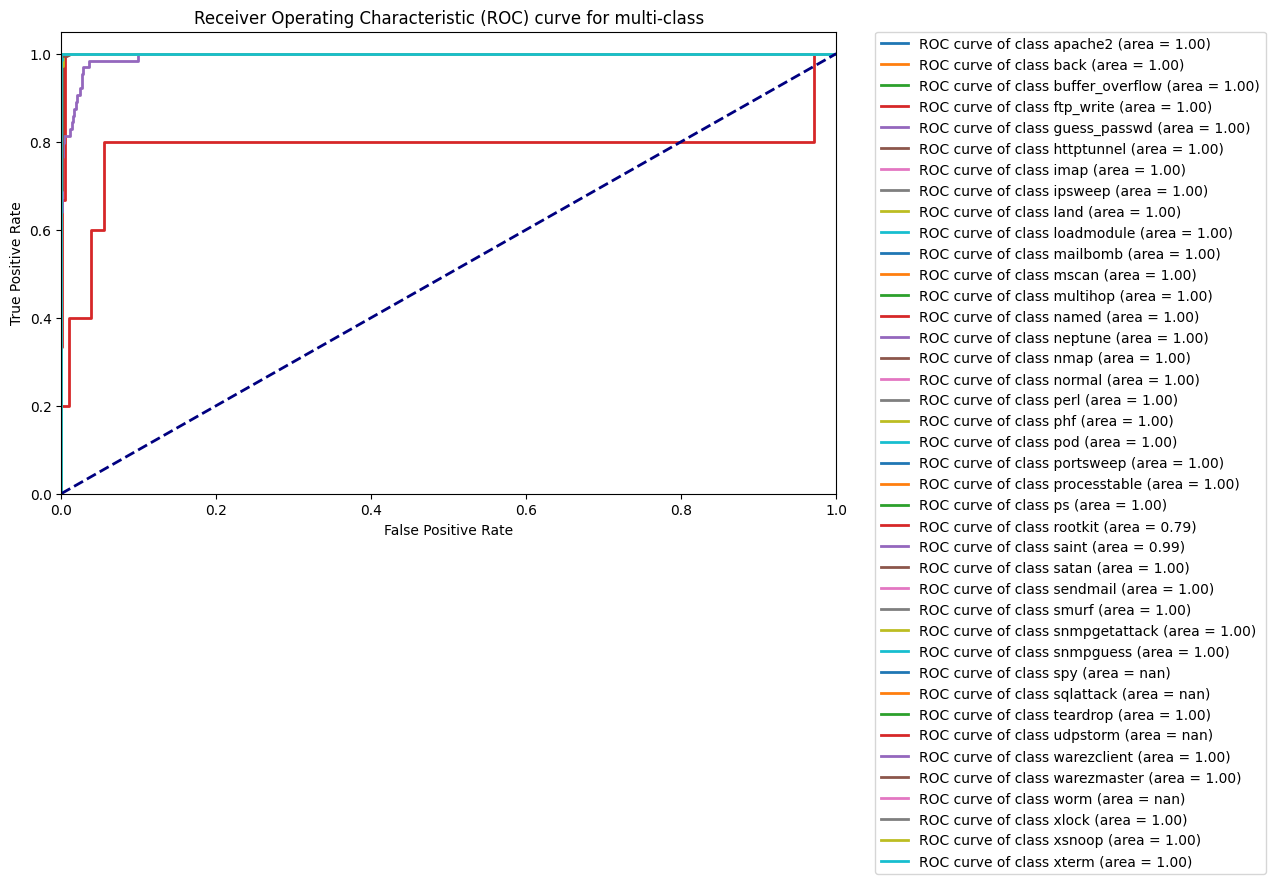

LogisticRegression Classifier


Metric     Value
0               Accuracy  0.996061
1      Precision (macro)  0.909801
2         Recall (macro)  0.796356
3       F1-score (macro)  0.815830
4    Precision (apache2)  1.000000
..                   ...       ...
119      Recall (xsnoop)  1.000000
120    F1-score (xsnoop)  1.000000
121    Precision (xterm)  1.000000
122       Recall (xterm)  0.333333
123     F1-score (xterm)  0.500000

[124 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

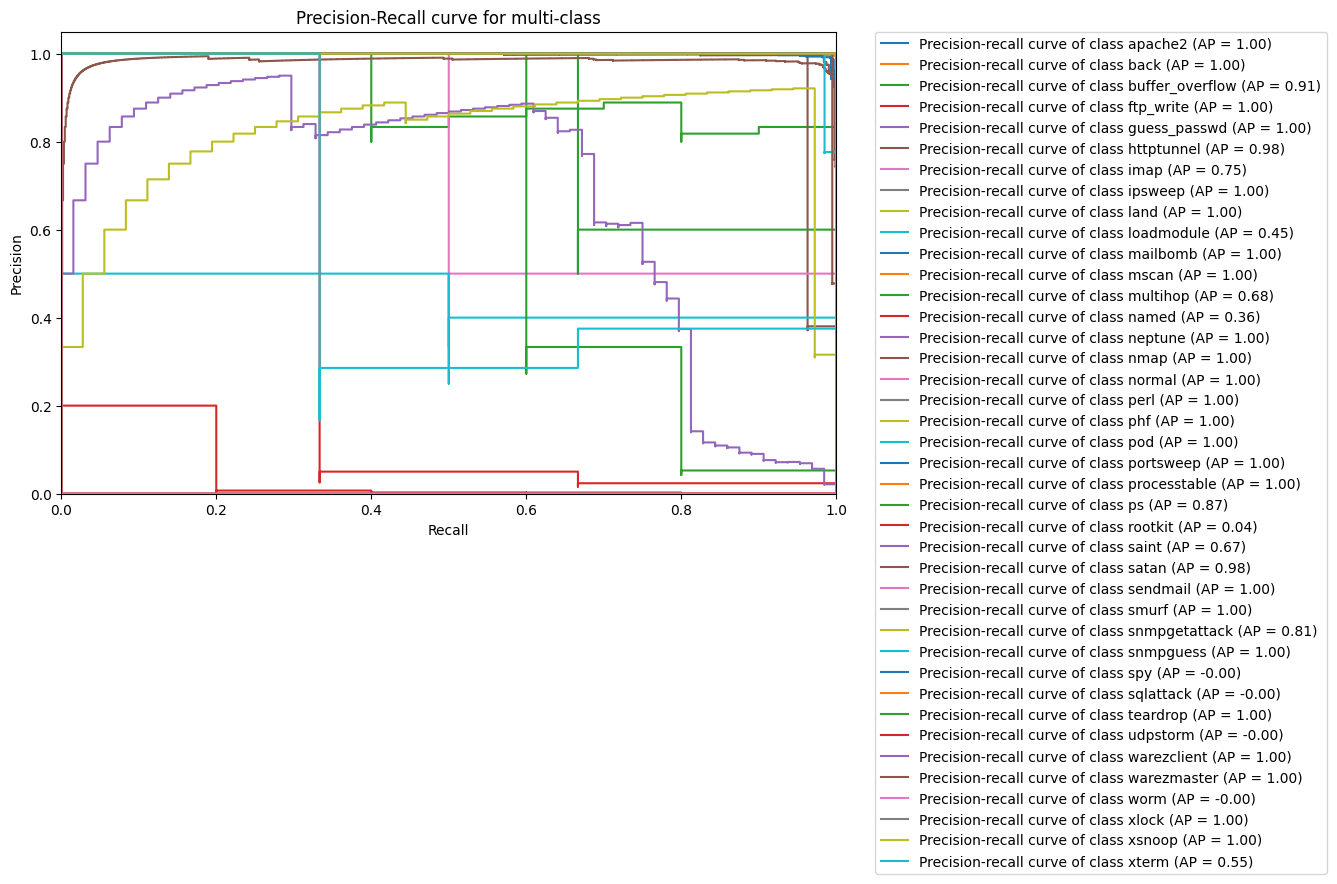

<ipython-input-21-6f21ff871c45>:140: RuntimeWarning: invalid value encountered in true_divide
  class_accuracies = class_corrects / class_counts


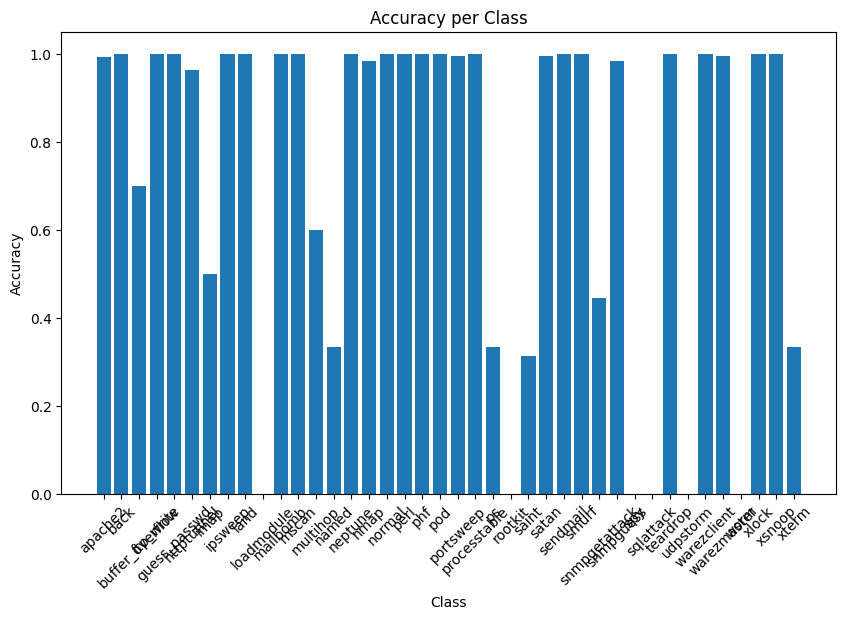

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


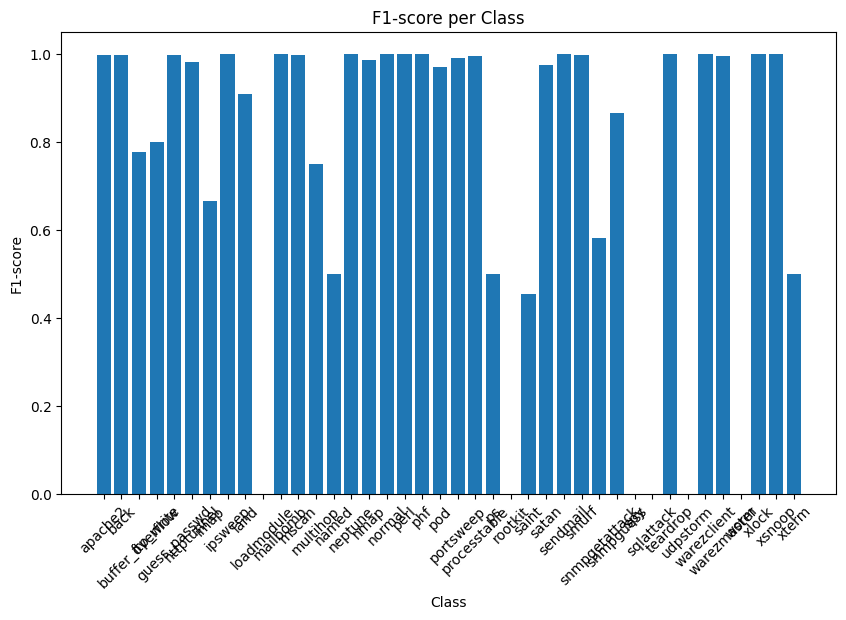

In [ ]:
# from sklearn.linear_model import LogisticRegression
# # One-hot encode the categorical columns
# cat_cols = ['protocol_type', 'service', 'flag']
# df = pd.get_dummies(df, columns=cat_cols)

# # Encode the labels
# label_encoder = LabelEncoder()
# df['label'] = label_encoder.fit_transform(df['label'])

# # Split the dataset into features and labels
# X = df.iloc[:, :-1].values
# y = df['label'].values

# # Split the data into training and testing datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Apply feature scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # Train the Logistic Regression Classifier
# lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
# lr_classifier.fit(X_train_scaled, y_train)
# # Make predictions
# y_pred = lr_classifier.predict(X_test_scaled)
# # Plot ROC curve
# y_score = lr_classifier.predict_proba(X_test_scaled)

# model_name = 'LogisticRegression'
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# # Print scores
# print("LogisticRegression Classifier")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)